# Imports

In [2]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from pylab import rcParams
import seaborn as sns
from array import array
import math
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import linregress
from scipy.stats import mannwhitneyu
import statistics
%matplotlib inline


# Useful functions

In [3]:
begins=[]
ends=[]
names =[]
with open ("CommonData/sequence.gb") as f:
    in_pep = False
    for l in f:
        if "mat_peptide" in l:
            begins.append(int(l.split()[1].split("..")[0]))
            ends.append(int(l.split()[1].split("..")[1]))
            in_pep = True
        elif in_pep :
            names.append(l.split("=")[1])
            in_pep = False
            
print(begins)
print(ends)
print(names)

[108, 474, 753, 978, 2490, 3546, 4224, 4614, 6465, 6846, 6915, 7668]
[473, 752, 977, 2489, 3545, 4223, 4613, 6464, 6845, 6914, 7667, 10376]
['"capsid"\n', '"propeptide"\n', '"membrane"\n', '"envelope"\n', '"NS1"\n', '"NS2A"\n', '"NS2B"\n', '"NS3"\n', '"NS4A"\n', '"2K"\n', '"NS4B"\n', '"NS5"\n']


In [4]:
# Interesting positions
#positions=[316,1670,1785,2340,5935,7172,8449,9165]
positions = [1670, 2340, 5662, 7172, 10006, 2193, 1785]
def plot_positions():
    for x in positions:
        plt.axvline(x=x, linewidth=1, linestyle=':', color="black")
        
def plot_genes(with_text=True):
    for i in range(len(begins)):
        plt.plot([begins[i], begins[i]], [0.99,1.0], linewidth=2, linestyle='-', color="black")
        if with_text:
            if i%2==0:
                plt.text (begins[i] + ((ends[i] - begins[i])/10), 1.005, (names[i].replace('"', ''))[0:3], size='xx-small')
            else:
                plt.text (begins[i] + ((ends[i] - begins[i])/10), 1.015, (names[i].replace('"', ''))[0:3], size='xx-small')
    plt.plot([ends[-1], ends[-1]], [0.99,1.0], linewidth=2, linestyle='-', color="black")



In [5]:
def synonymous (row):
    if row['null'] or (row['Consensus_aa']==row['Secondbase_aa'] ):
        return "synonymous" 
    else:
        return "non-synonymous"

def add_columns(table):
    table['null'] = (table['Secondbase_aa']).isnull()
    table['is_synonymous'] = table.apply (lambda row: synonymous (row),axis=1)
    table['1_major_variant_frequency'] = 1.0 - table['Major_variant_frequency_quality_corrected']

In [6]:
def is_increasing(minor_frequencies):
    #print(minor_frequencies)
    tolerance = 0.01
    minimum_increase = 0.1
    previous = minor_frequencies[0]
    if minor_frequencies[-1] - minor_frequencies[0] < minimum_increase:
        return False
    for m in range(1,len(minor_frequencies)):
        if previous < minor_frequencies[m] or previous < minor_frequencies[m] + tolerance:
            #print(str(previous) + " < " + str(minor_frequencies[m]))
            previous = minor_frequencies[m]
        else:
            return False
    return True


# Strict definition of an increasing position
def is_strictly_increasing(minor_frequencies):
    #print(minor_frequencies)
    previous = minor_frequencies[0]
    for m in range(1,len(minor_frequencies)):
        if previous < minor_frequencies[m]:
            #print(str(previous) + " < " + str(minor_frequencies[m]))
            previous = minor_frequencies[m]
        else:
            return False
    return True


def get_variant_frequency(variant, table, i):
    sum_of_bases = table['As_quality_corrected'][i]+table['Cs_quality_corrected'][i]+table['Gs_quality_corrected'][i]+table['Ts_quality_corrected'][i]+table['Ns_quality_corrected'][i]
    if variant == "A":
        return table["As_quality_corrected"][i] / sum_of_bases
    elif variant == "C":
        return table["Cs_quality_corrected"][i] / sum_of_bases
    elif variant == "G":
        return table["Gs_quality_corrected"][i] / sum_of_bases
    elif variant == "T":
        return table["Ts_quality_corrected"][i] / sum_of_bases
    else:
        return np.nan
        

def get_increasing_variants(tables):
    num_tables = len(tables)
    first = tables[0]
    last = tables[num_tables-1]
    major = ""
    minor = ""
    major_frequencies = array('d',[0.0]*num_tables)
    minor_frequencies = array('d',[0.0]*num_tables)
    increasingVariants = dict()
    for i in first["Position"]:
        major = first["Major_variant"][i]
        #print(last['Major_variant_frequency_quality_corrected'][i])
        major_frequencies[0] = first['Major_variant_frequency_quality_corrected'][i]
        if major == last["Major_variant"][i]:
            minor = last["Second_variant"][i]
        else:
            minor = last["Major_variant"][i]
        minor_frequencies[0] = get_variant_frequency(minor, first, i)
        for table_id in range(1, num_tables):
            major_frequencies[table_id] = get_variant_frequency(major, tables[table_id], i)
            minor_frequencies[table_id] = get_variant_frequency(minor, tables[table_id], i)
        if is_increasing(minor_frequencies):
            increasingVariants[i] = [major_frequencies.tolist(), minor_frequencies.tolist()]
    return increasingVariants


def printMajorFrequencyThroughSamples(tables, numPos):
    major = tables[0]['Major_variant'][numPos]
    last_major = tables[0]['Major_variant'][numPos]
    print("Position "+ str(numPos) +", Major variant in first sample: " + major)
    print("Position "+ str(numPos) +", Frequencies of "+major+" through the samples: ")
    for i in range(len(tables)):
        print("\t"+str(get_variant_frequency(major, tables[i], numPos)))
    print("Position "+ str(numPos) +", Major variant in last sample: " + tables[-1]['Major_variant'][numPos])

    
def printMajorFrequencyThroughSamples_2340_7172(tables):
    printMajorFrequencyThroughSamples(tables, 2340)
    printMajorFrequencyThroughSamples(tables, 7172)

In [7]:
## Function to get colors by time points
def color_from_name (name, colors):
    if "3_" in name:
        return colors[0]
    if "6_" in name:
        return colors[1]
    if "9_" in name:
        return colors[2]
    if "12_" in name:
        return colors[3]
    if "18_" in name:
        return colors[4]
    if "24_" in name:
        return colors[5]
    if "51_" in name:
        return colors[6]
    else:
        print("PROBLEM: did not find " + name)

def colors_from_names (names):
    colors= list()
    pal = sns.color_palette( n_colors=7 )
    hexa_cols = pal.as_hex()
    for name in names:
        colors.append(color_from_name (name, hexa_cols) )
    return colors

# Reading the data

In [8]:
# Control runs, replicate A
DD3_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD3A_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD3_A)
DD6_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD6A_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD6_A)
DD9_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD9A_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD9_A)
DD12_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD12A_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD12_A)
DD18_A = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1DD18A_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD18_A)
DD24_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD24A_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD24_A)
DD51_A = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD51A_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD51_A)
DD51_A_no_reamp = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD51Anoreamplification_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(DD51_A_no_reamp)

tables_A = [DD3_A, DD6_A, DD9_A, DD12_A, DD18_A, DD24_A, DD51_A]
names_A = ["DD3_A", "DD6_A", "DD9_A", "DD12_A", "DD18_A", "DD24_A", "DD51_A"]
colors_A = colors_from_names(names_A)

In [9]:
# Control runs, replicate D
DD3_D = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD3D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(DD3_D)
DD6_D = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD6D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(DD6_D)
DD9_D = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD9D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(DD9_D)
DD12_D = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD12D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(DD12_D)
DD18_D = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1DD18D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(DD18_D)
DD24_D = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD24D_1_sequence.txt.assembled.fastq_mapped_AA.csv")
add_columns(DD24_D)

tables_D = [DD3_D, DD6_D, DD9_D, DD12_D, DD18_D, DD24_D]
names_D = ["DD3_D", "DD6_D", "DD9_D", "DD12_D", "DD18_D", "DD24_D"]
colors_D = colors_from_names(names_D)

In [10]:
# Control runs, replicate E
DD3_E = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1DD3E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
DD6_E = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD6E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
DD9_E = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1DD9E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
DD12_E = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1DD12E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
DD18_E = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1DD18E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
DD24_E = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1DD24E_1_sequence.txt.assembled.fastq_mapped_AA.csv")
DD24crude_E = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1DD24Ecrude_1_sequence.txt.assembled.fastq_mapped_AA.csv")

add_columns(DD3_E)
add_columns(DD6_E)
add_columns(DD9_E)
add_columns(DD12_E)
add_columns(DD18_E)
add_columns(DD24_E)
add_columns(DD24crude_E)

tables_E = [DD3_E, DD6_E, DD9_E, DD12_E, DD18_E, DD24_E]
names_E = ["DD3_E", "DD6_E", "DD9_E", "DD12_E", "DD18_E", "DD24_E"]
colors_E = colors_from_names(names_E)

In [11]:
# All tables
all_tables = tables_A+tables_D+tables_E
all_table_names = ["DD3_A", "DD6_A", "DD9_A", "DD12_A", "DD18_A", "DD24_A", "DD51_A", "DD3_D", "DD6_D", "DD9_D", "DD12_D", "DD18_D", "DD24_D", "DD3_E", "DD6_E", "DD9_E", "DD12_E", "DD18_E", "DD24_E"]

all_experiments = [tables_A,tables_D,tables_E]
all_experiment_names = ["tables_A","tables_D","tables_E"]

In [12]:
## Function to get colors by experiment
def color_from_name_by_experiment (name, colors):
    if "DD" in name:
        if "_A" in name:
            return colors[0]
        if "_D" in name:
            return colors[1]
        if "_E" in name:
            return colors[2]
    else:
        print("PROBLEM: did not find " + name)

def colors_from_names_by_experiment (names):
    colors= list()
    hexa_cols = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]  #sns.diverging_palette(255, 133, n=6, center="dark")
    #hexa_cols = pal.as_hex()
    for name in names:
        colors.append(color_from_name_by_experiment (name, hexa_cols) )
    return colors

In [13]:
# Tables per round
tables_3 = [DD3_A, DD3_D, DD3_E]
table_names_3 = ["DD3_A", "DD3_D", "DD3_E"]

tables_6 = [DD6_A, DD6_D, DD6_E]
table_names_6 = ["DD6_A", "DD6_D", "DD6_E"]

tables_9 = [DD9_A, DD9_D, DD9_E]
table_names_9 = ["DD9_A", "DD9_D", "DD9_E"]

tables_12 = [DD12_A, DD12_D, DD12_E]
table_names_12 = ["DD12_A", "DD12_D", "DD12_E"]

tables_18 = [DD18_A, DD18_D, DD18_E]
table_names_18 = ["DD18_A", "DD18_D", "DD18_E"]

tables_24 = [DD24_A, DD24_D, DD24_E]
table_names_24 = ["DD24_A", "DD24_D", "DD24_E"]

tables_51 = [DD51_A]
table_names_51 = ["DD51_A"]

# colors per round
colors_3 = colors_from_names_by_experiment(table_names_3)
colors_6 = colors_from_names_by_experiment(table_names_6)
colors_9 = colors_from_names_by_experiment(table_names_9)
colors_12 = colors_from_names_by_experiment(table_names_12)
colors_18 = colors_from_names_by_experiment(table_names_18)
colors_24 = colors_from_names_by_experiment(table_names_24)
colors_51 = colors_from_names_by_experiment(table_names_51)

# Coverage plots

In [14]:
def plotCoverage(tables, names):
    variable = 'Coverage'
    sample = list()
    posList = list()
    variableList = list()
    for i in range(len(names)):
        sample = sample + len(tables[i][variable]) * [names[i]]
        posList.append(tables[i]['Position'])
        variableList.append(tables[i][variable])
    positions = pd.concat(posList)
    variableValues = pd.concat(variableList)
    overlay_table_concat = pd.DataFrame ({'Position':positions, variable:variableValues, 'sample':sample})
    sns.lmplot( x="Position", y=variable, data=overlay_table_concat, fit_reg=False, hue='sample', legend=False, size=7, aspect=2, lowess=True,scatter_kws={"s": 5})
    plt.legend(loc='lower right')
    plt.ylim(0, 300000)
    plot_positions()
    plot_genes()
    # Now a plot without text
    g=sns.lmplot( x="Position", y=variable, data=overlay_table_concat, fit_reg=False, hue='sample', legend=False, size=7, aspect=2, lowess=True,scatter_kws={"s": 5})
    #plt.legend(loc='lower right')
    plt.ylim(0, 300000)
    plot_positions()
    plot_genes(False)
    g.set_ylabels("") 
    g.set_xlabels("") 
    g.set(xticks=[],yticks=[0,50000,100000,150000, 200000, 250000, 300000])
    # Now a plot without text and flat
    g=sns.lmplot( x="Position", y=variable, data=overlay_table_concat, fit_reg=False, hue='sample', legend=False, size=7, aspect=4, lowess=True,scatter_kws={"s": 5})
    #plt.legend(loc='lower right')
    plt.ylim(0, 300000)
    plot_positions()
    plot_genes(False)
    g.set_ylabels("") 
    g.set_xlabels("") 
    g.set(xticks=[],yticks=[0,50000,100000,150000, 200000, 250000, 300000])
    

## DD_A

/home/boussau/anaconda3/lib/python3.7/site-packages/seaborn/regression.py:573: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


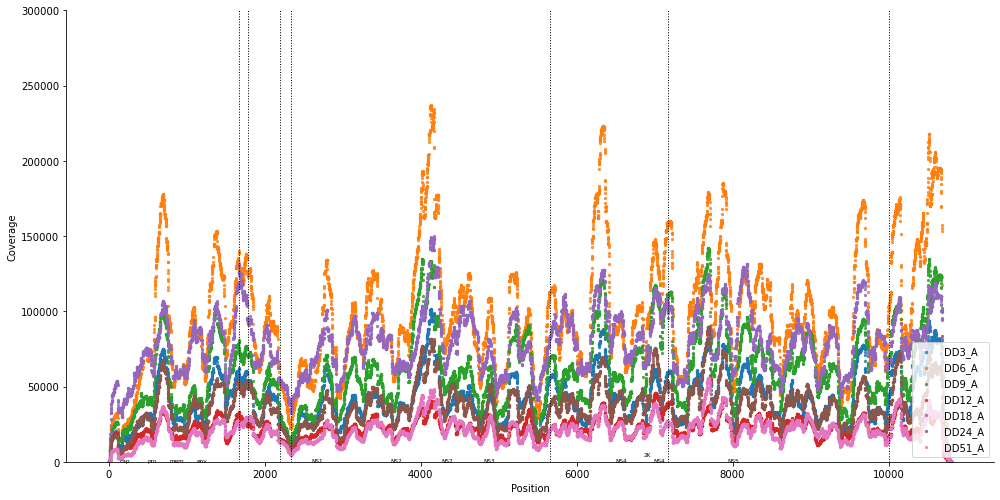

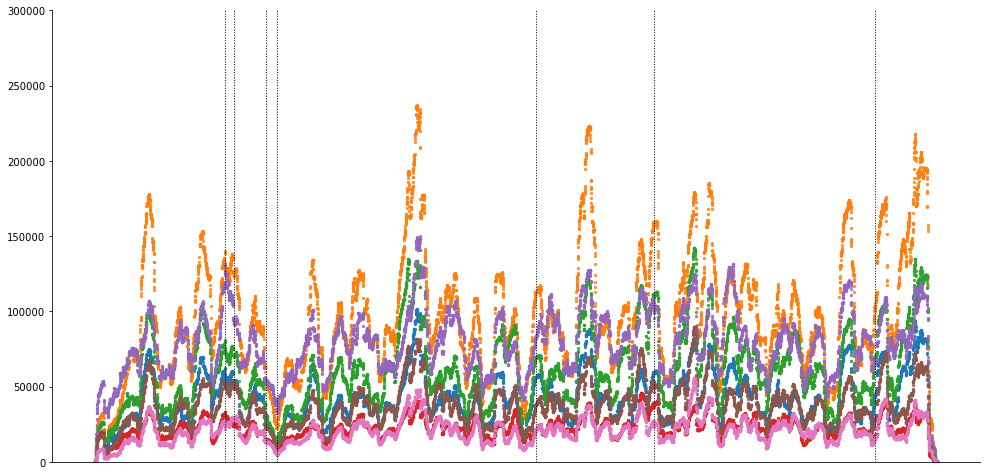

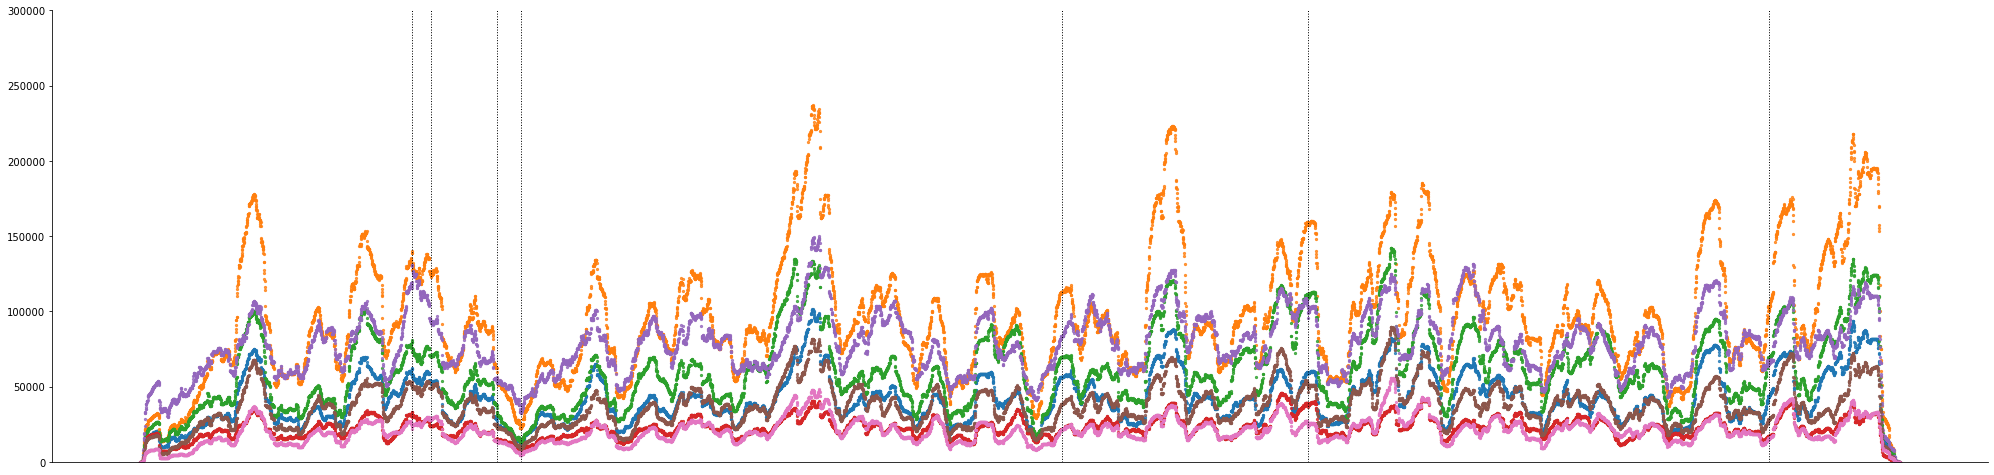

In [15]:
sns.set_palette(colors_A)
sns.color_palette(colors_A)
plotCoverage(tables_A, names_A)

## DD_D

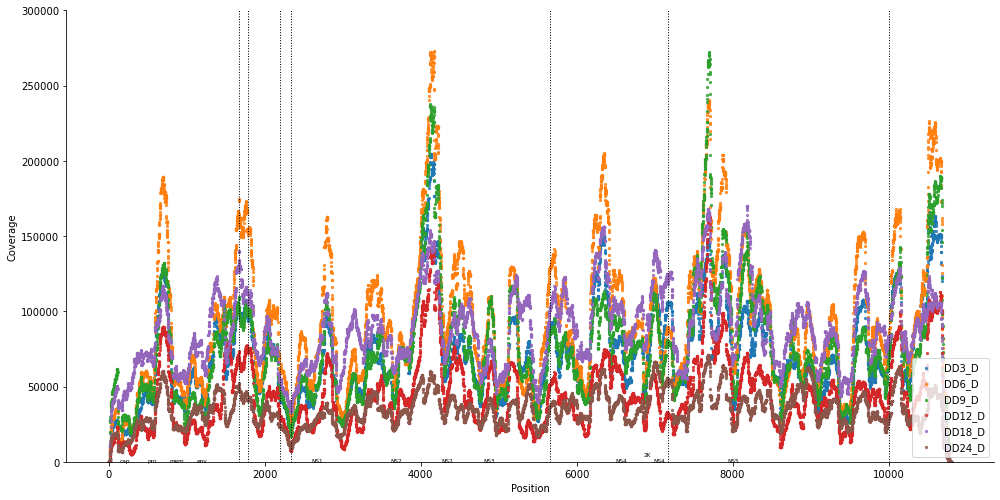

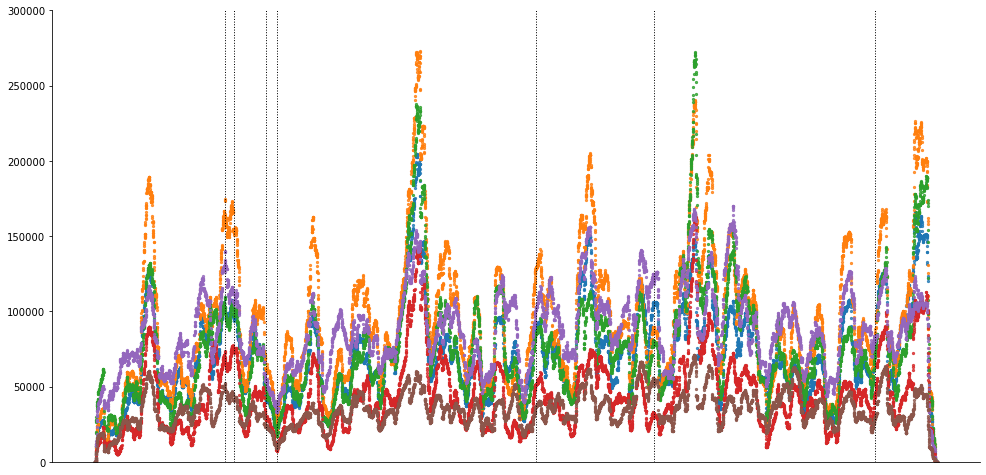

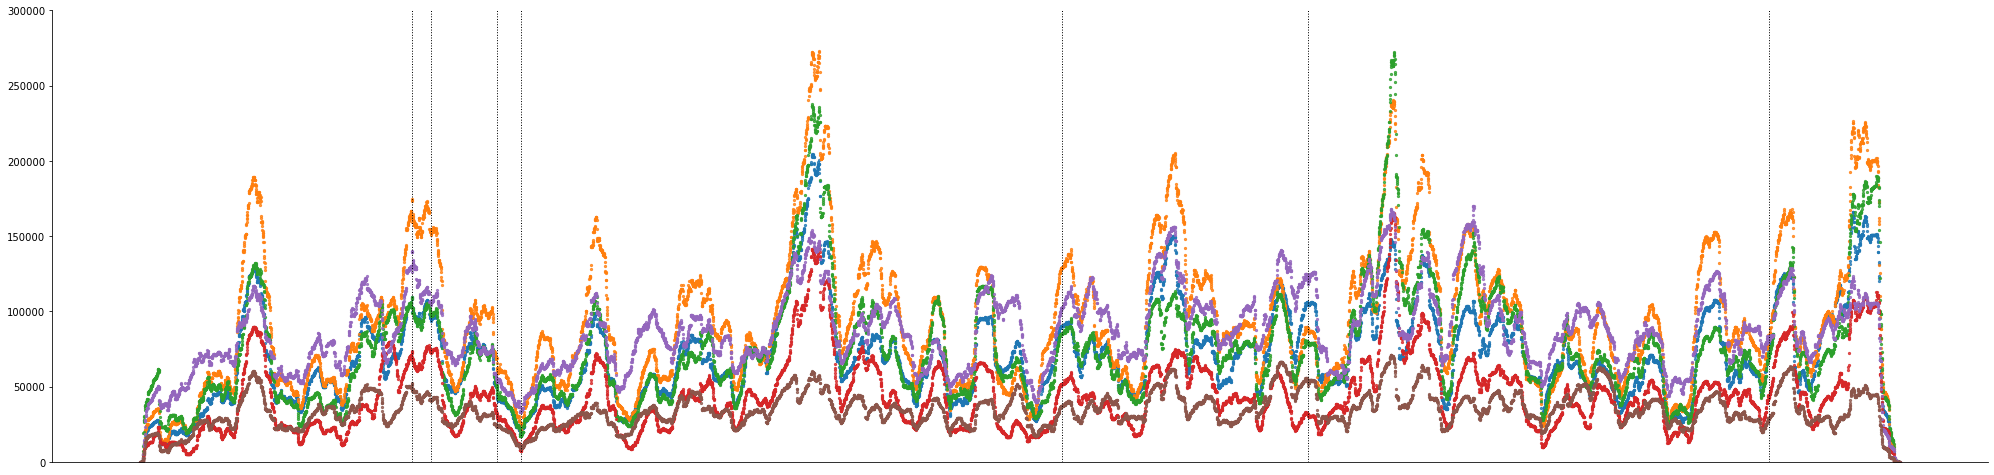

In [16]:
sns.set_palette(colors_D)
sns.color_palette(colors_D)
plotCoverage(tables_D, names_D)

In [17]:
print(names_A)
print(colors_A)
print(names_D)
print(colors_D)


['DD3_A', 'DD6_A', 'DD9_A', 'DD12_A', 'DD18_A', 'DD24_A', 'DD51_A']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
['DD3_D', 'DD6_D', 'DD9_D', 'DD12_D', 'DD18_D', 'DD24_D']
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']


## DD_E

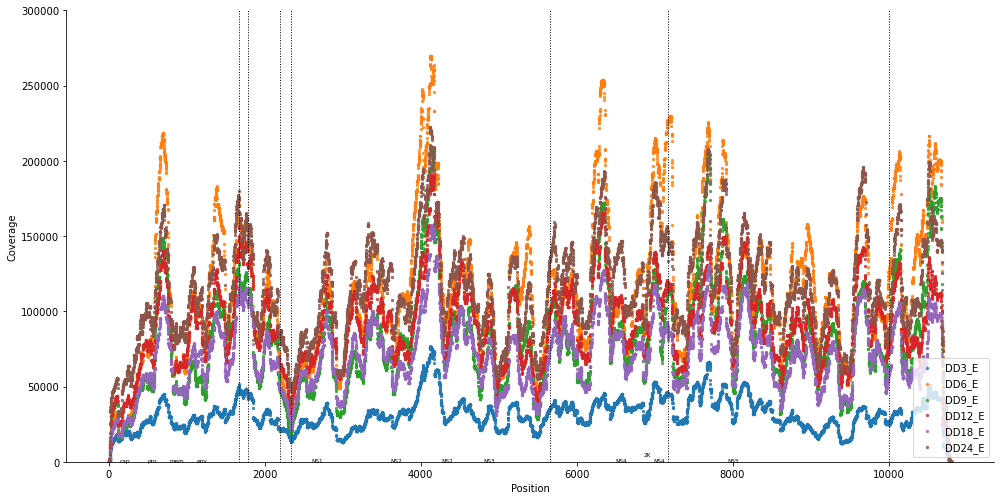

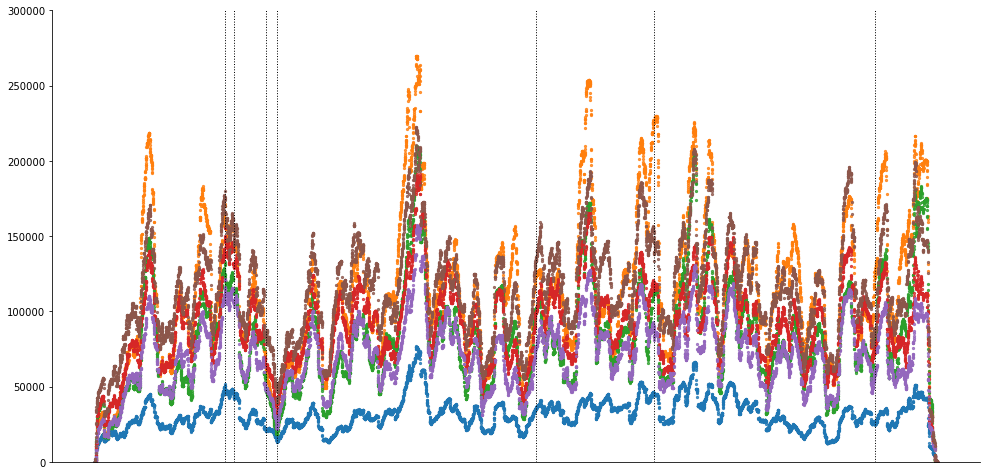

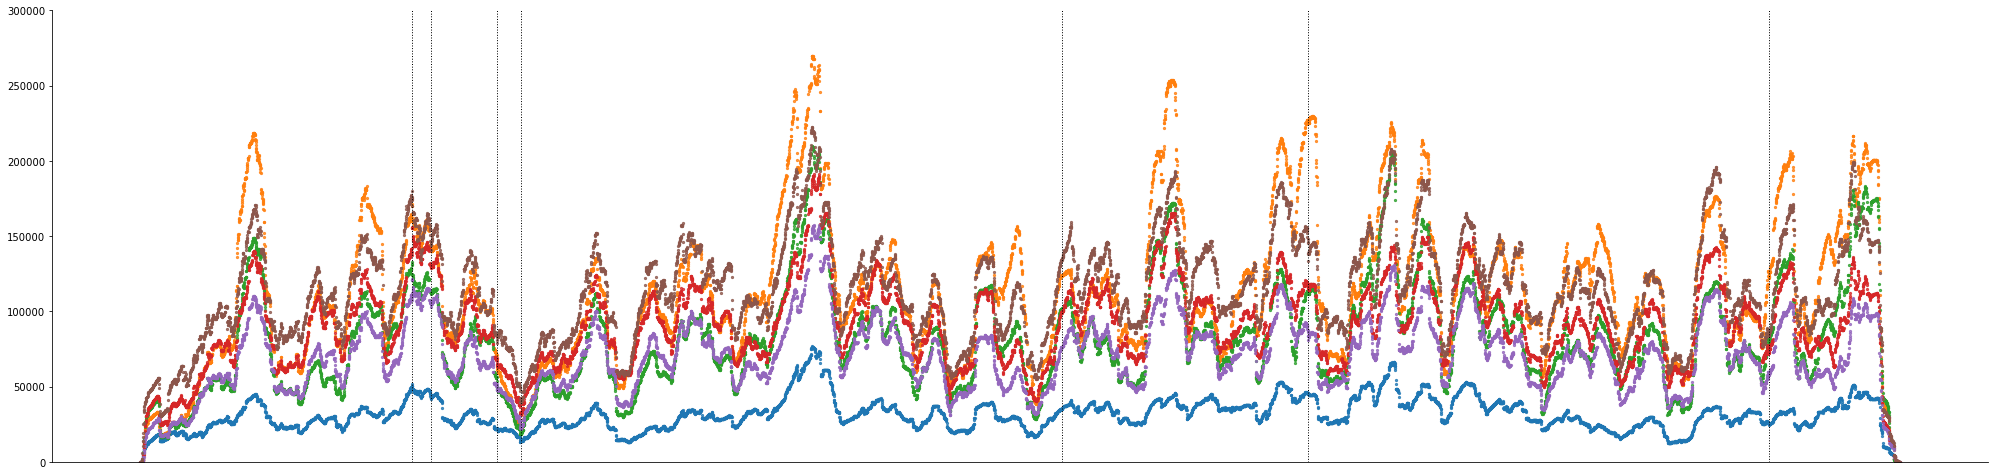

In [18]:
sns.set_palette(colors_E)
sns.color_palette(colors_E)
plotCoverage(tables_E, names_E)

# Plots per round

## Round 3

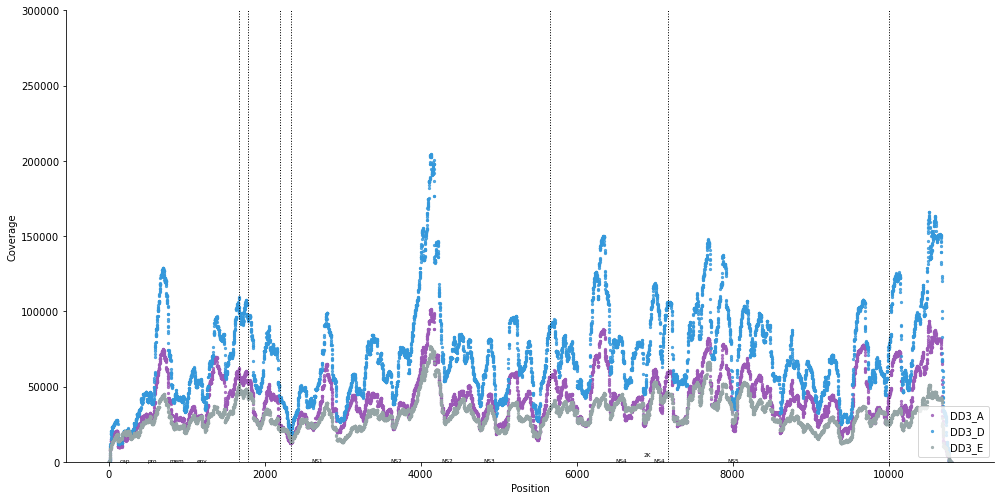

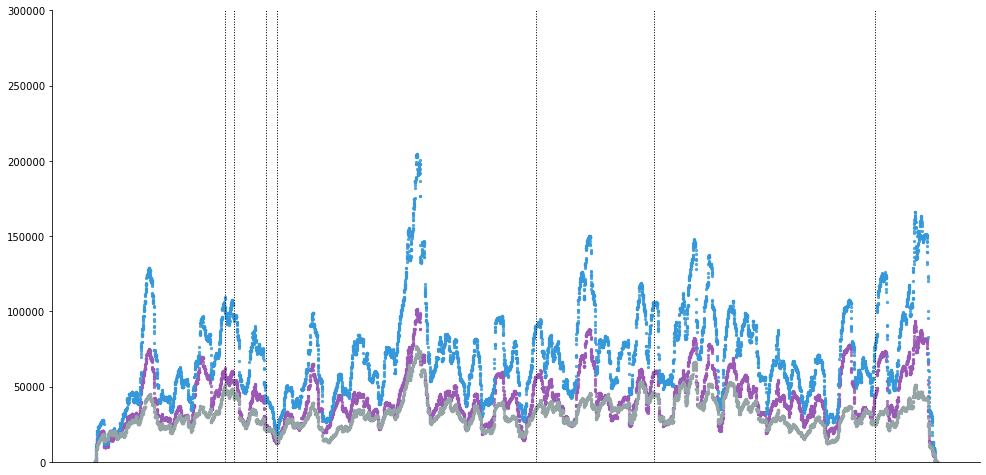

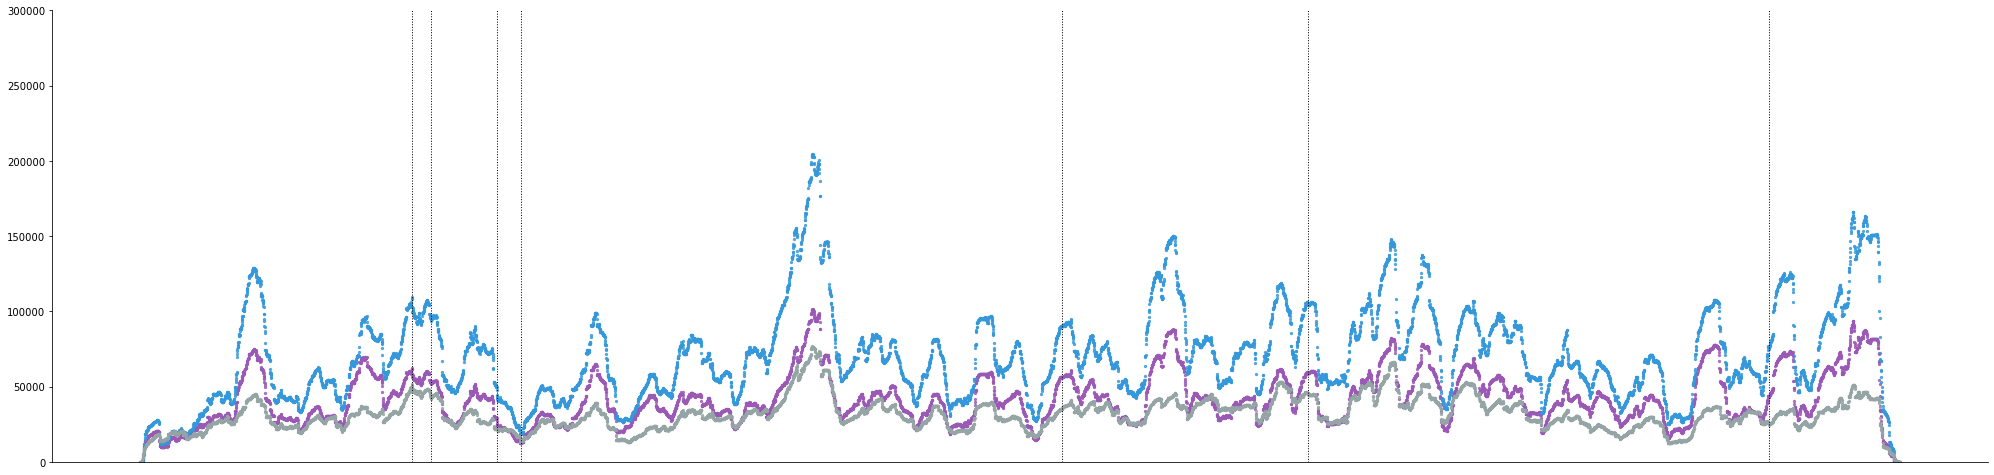

In [19]:
sns.set_palette(colors_3)
plotCoverage(tables_3, table_names_3)

## Round 6

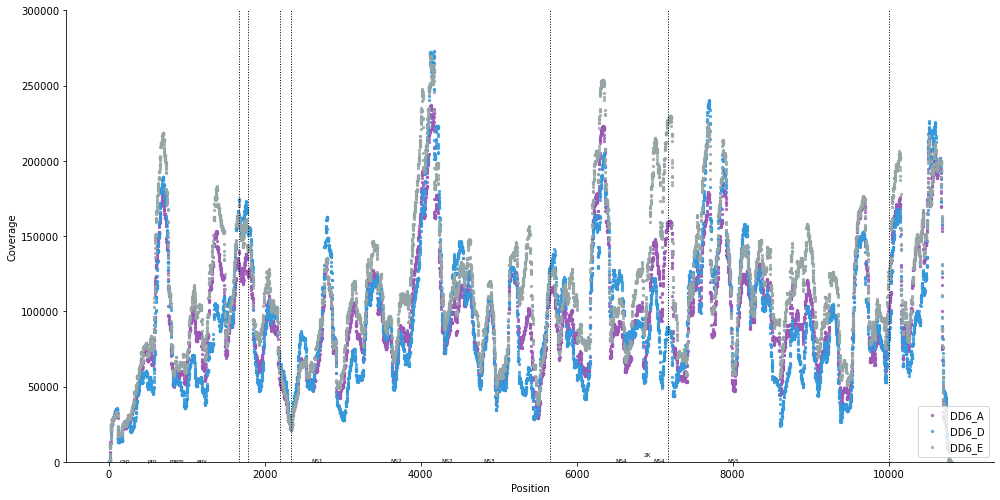

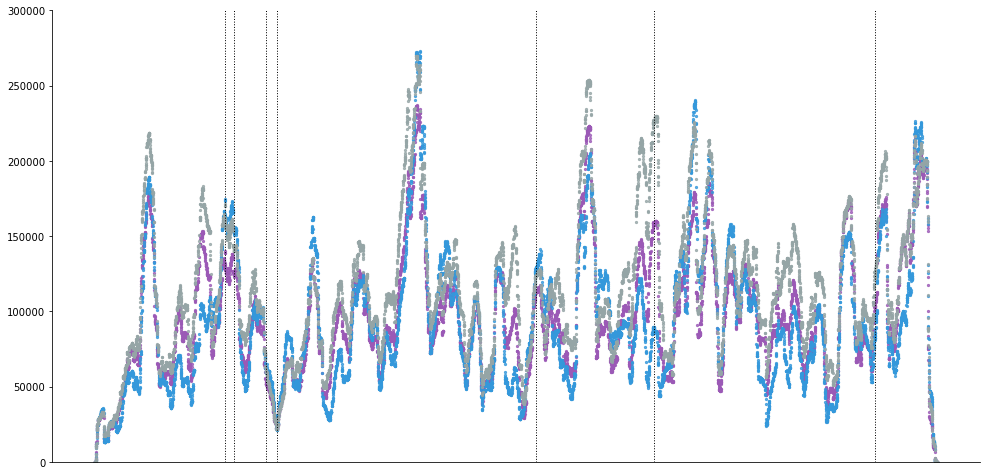

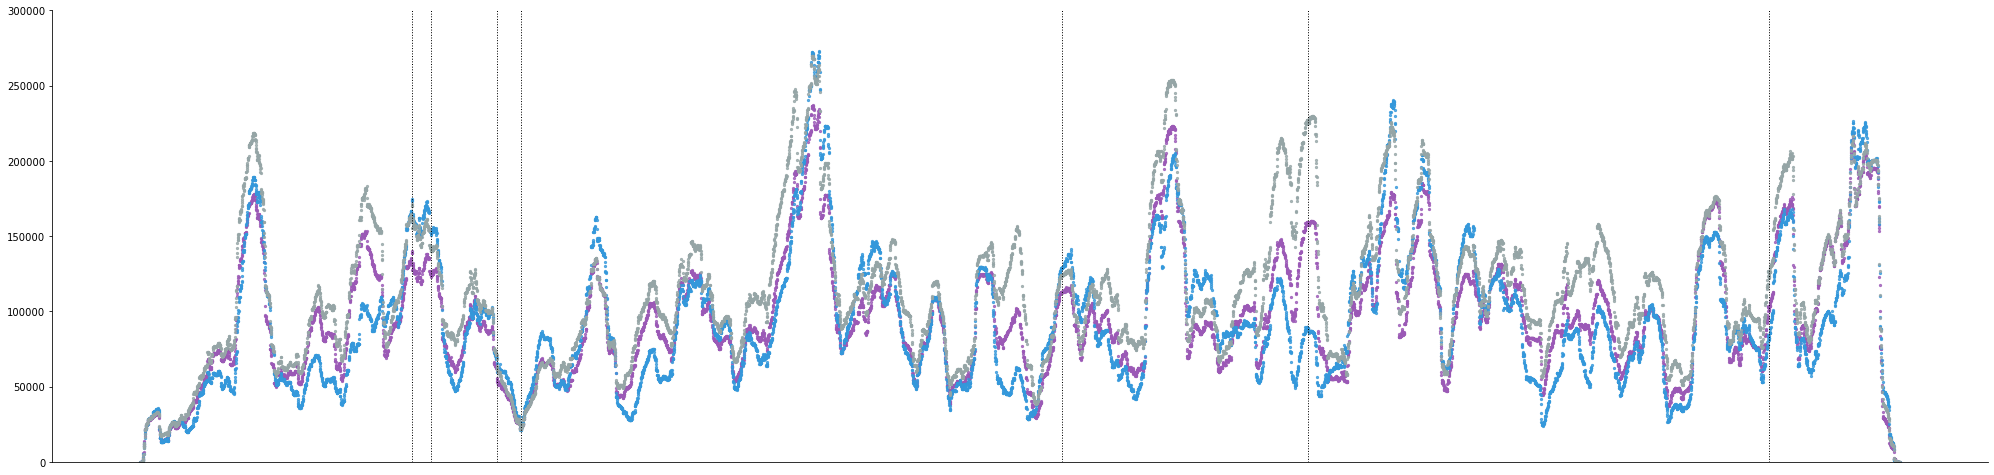

In [20]:
sns.set_palette(colors_6)

plotCoverage(tables_6, table_names_6)

## Round 9

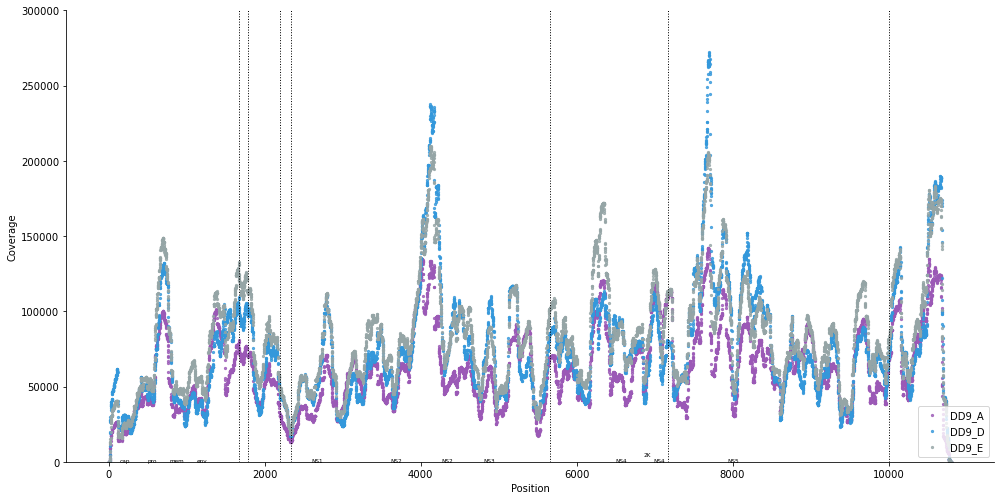

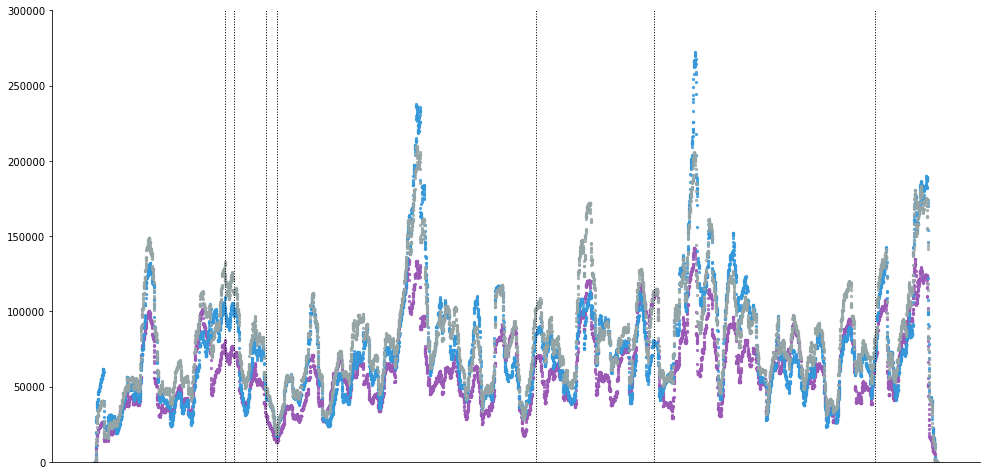

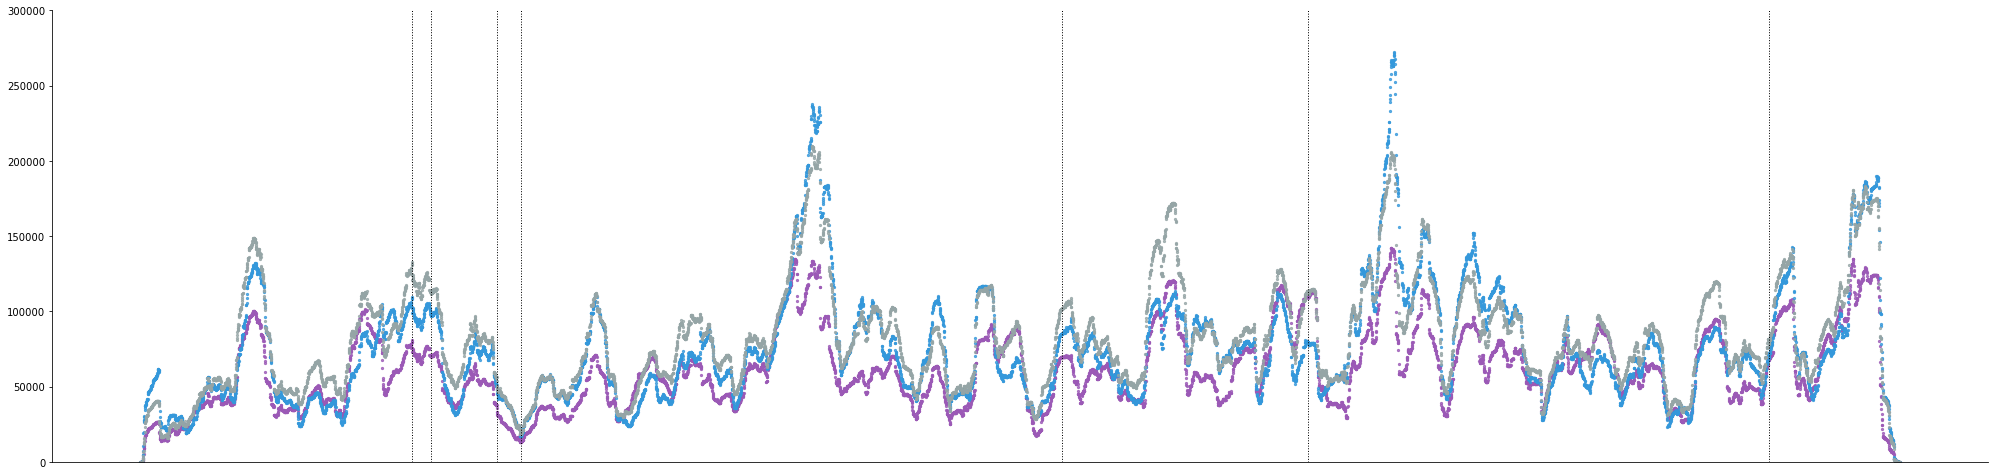

In [21]:
sns.set_palette(colors_9)
plotCoverage(tables_9, table_names_9)

## Round 12

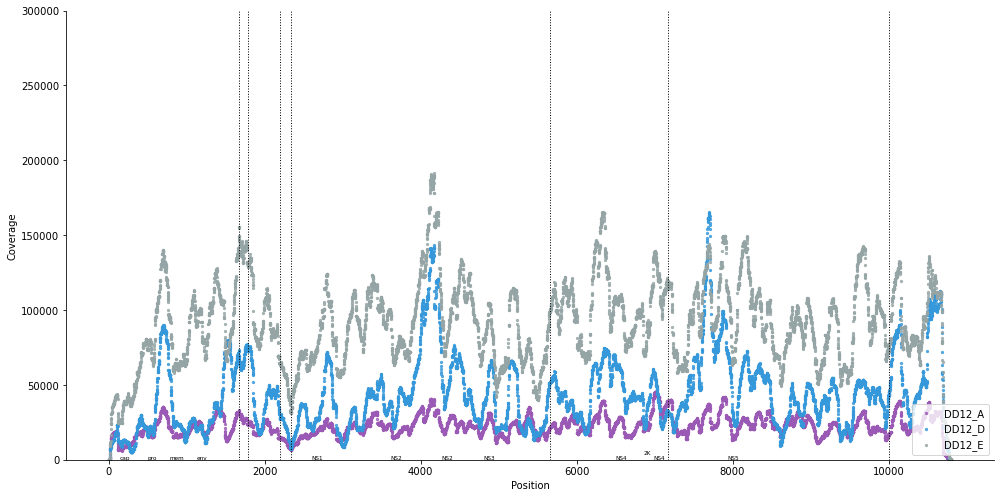

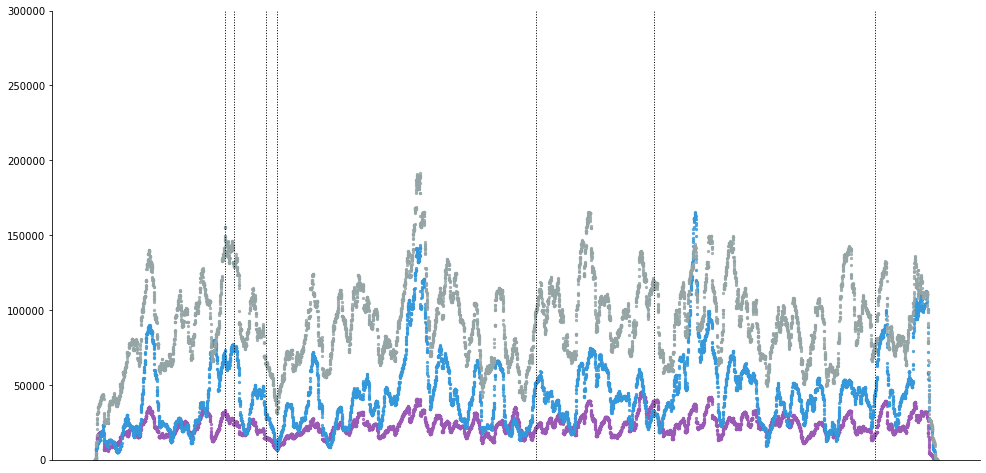

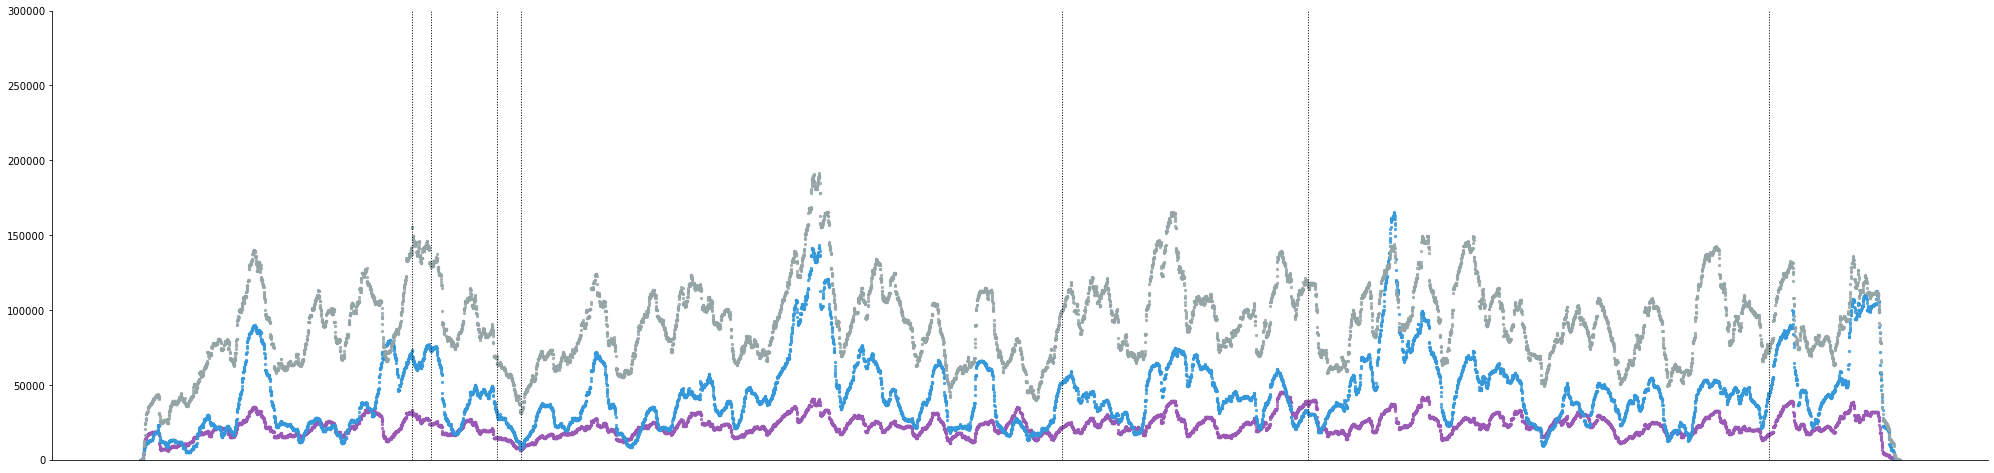

In [22]:
sns.set_palette(colors_12)

plotCoverage(tables_12, table_names_12)

## Round 18

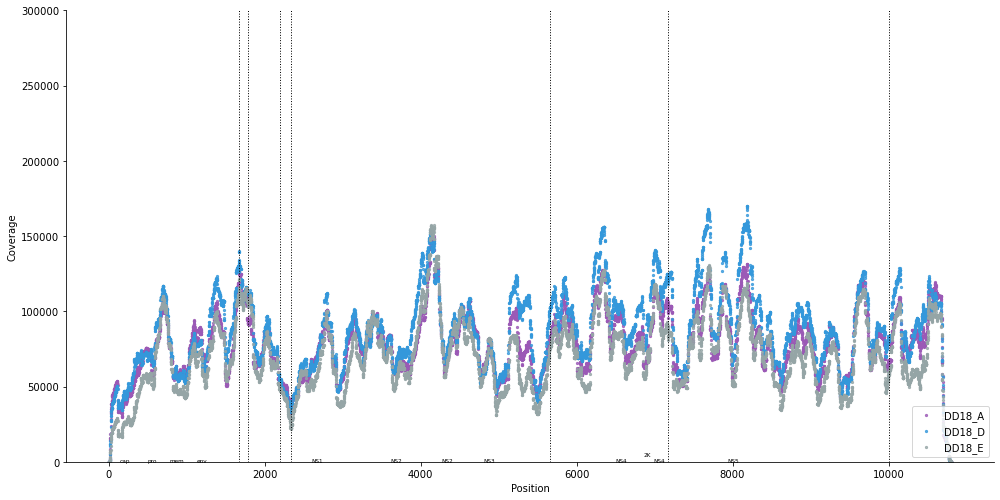

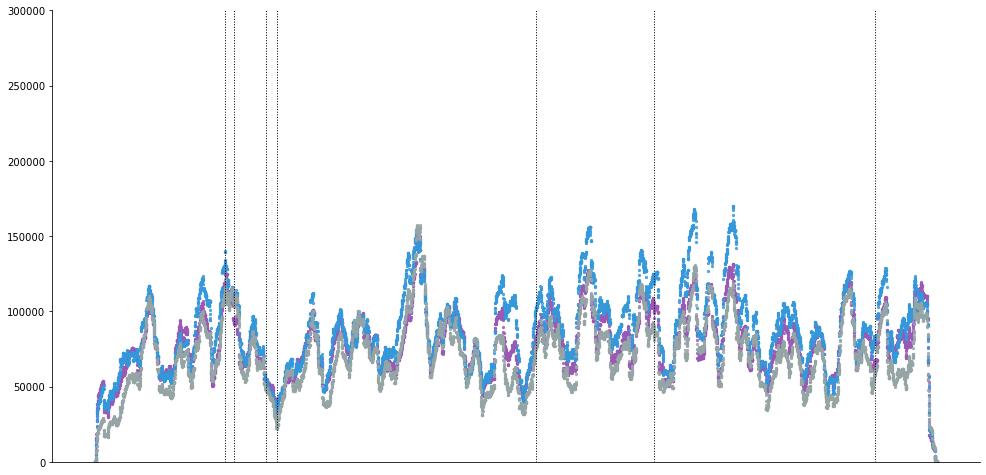

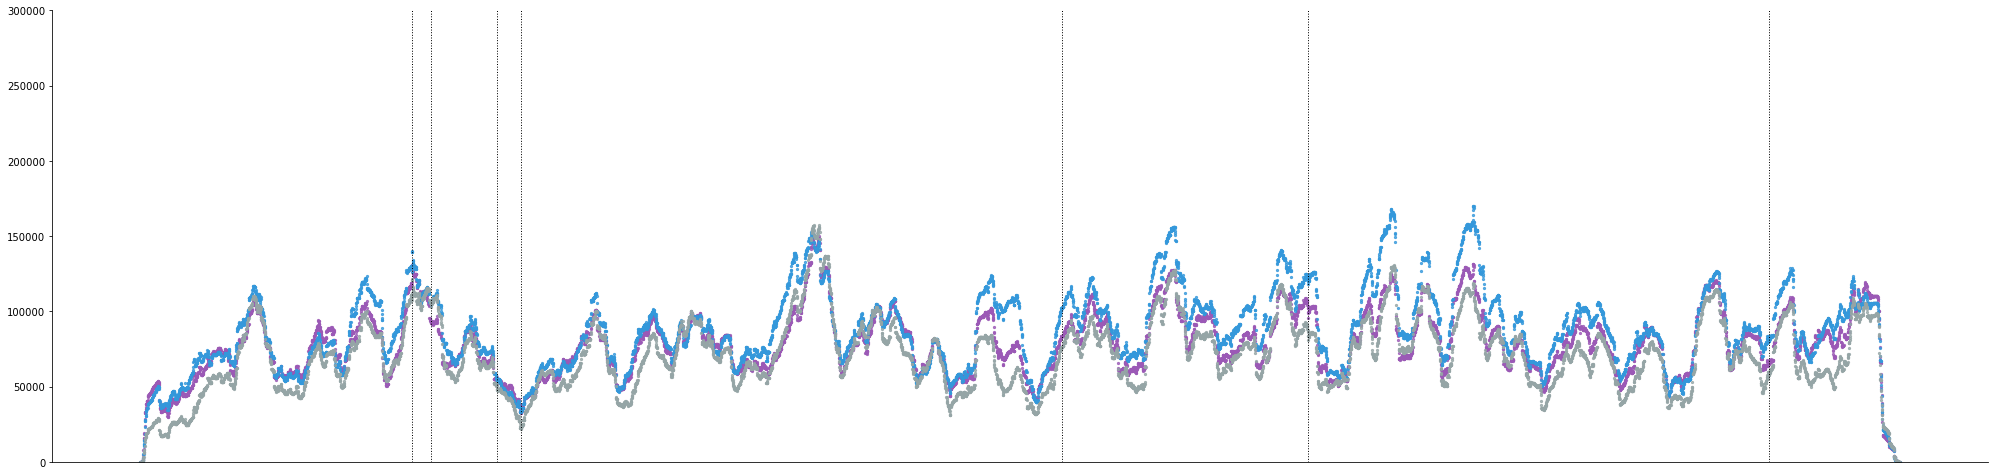

In [23]:
sns.set_palette(colors_18)

plotCoverage(tables_18, table_names_18)

## Round 24

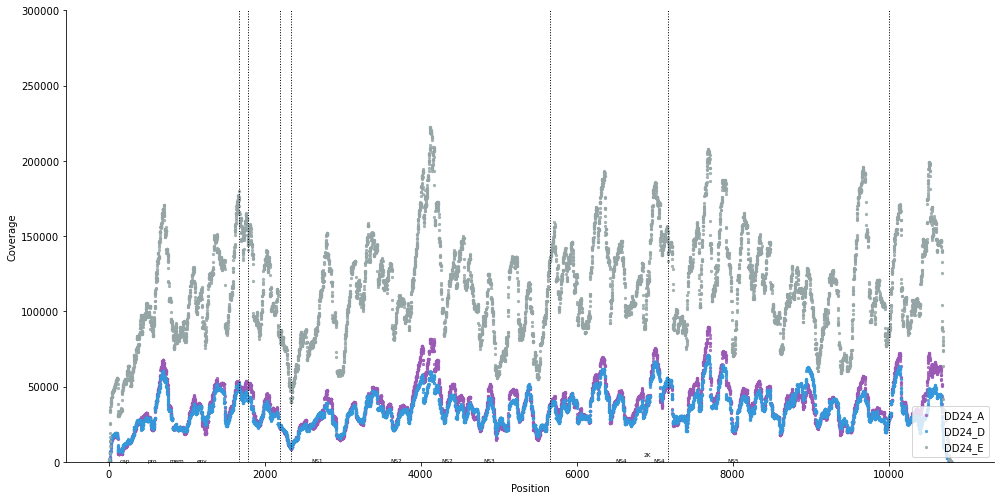

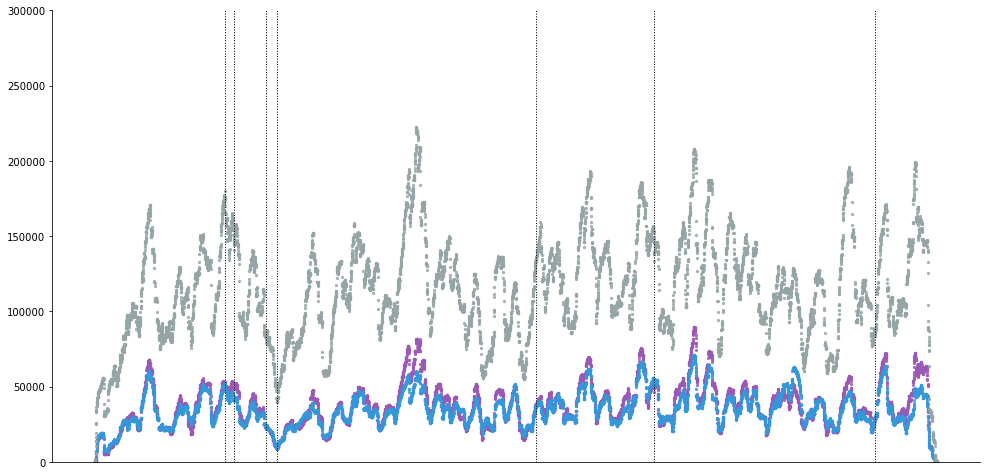

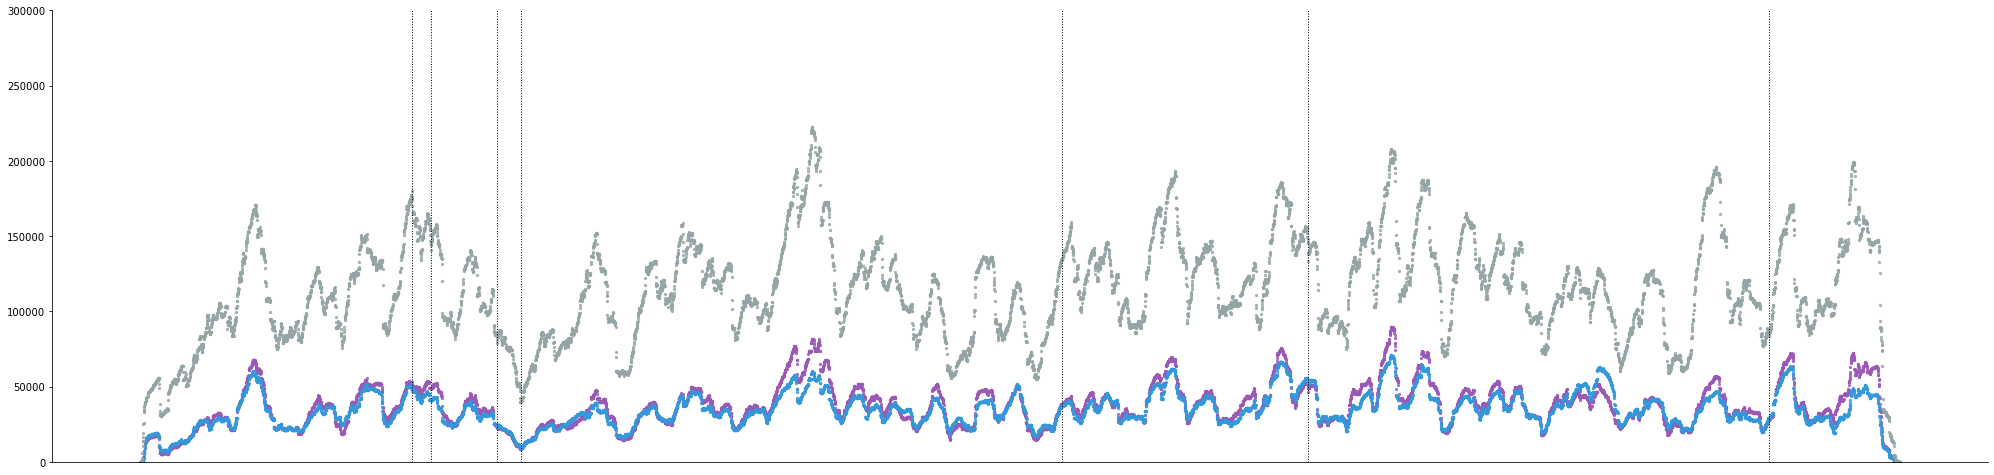

In [24]:
sns.set_palette(colors_24)
plotCoverage(tables_24, table_names_24)

## Round 51

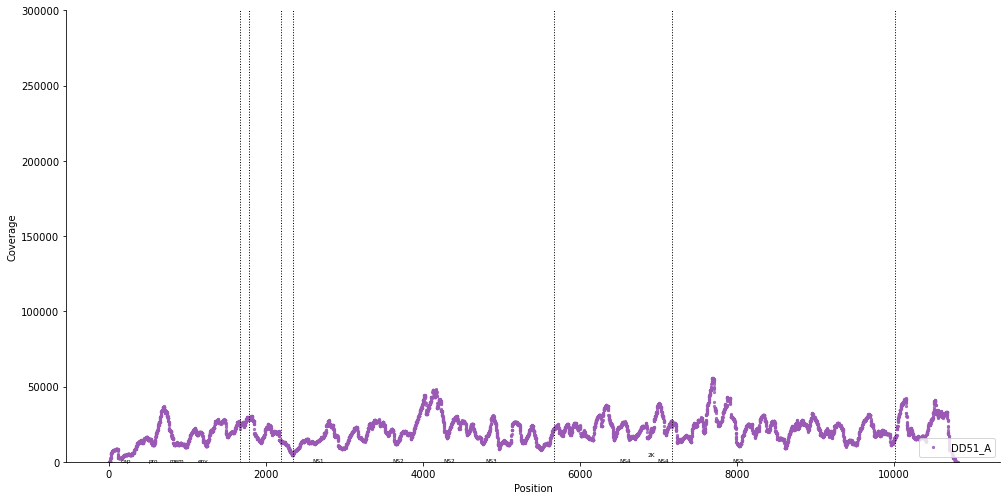

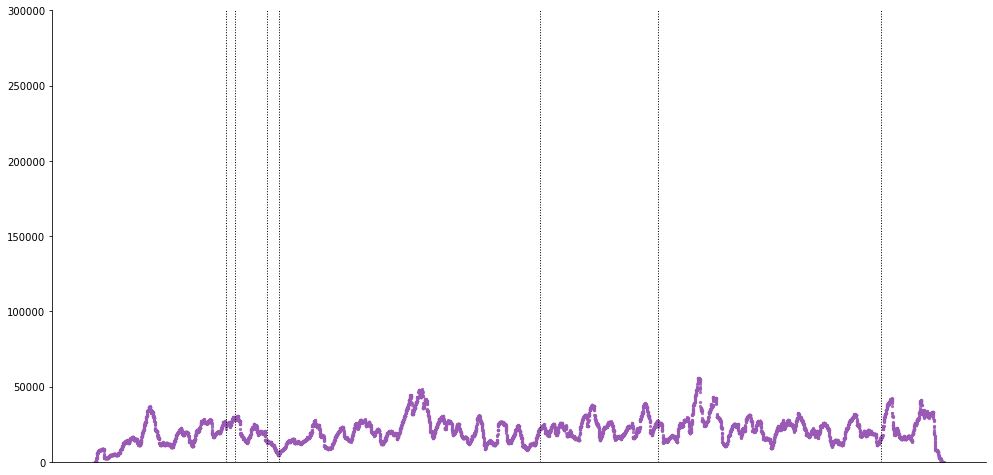

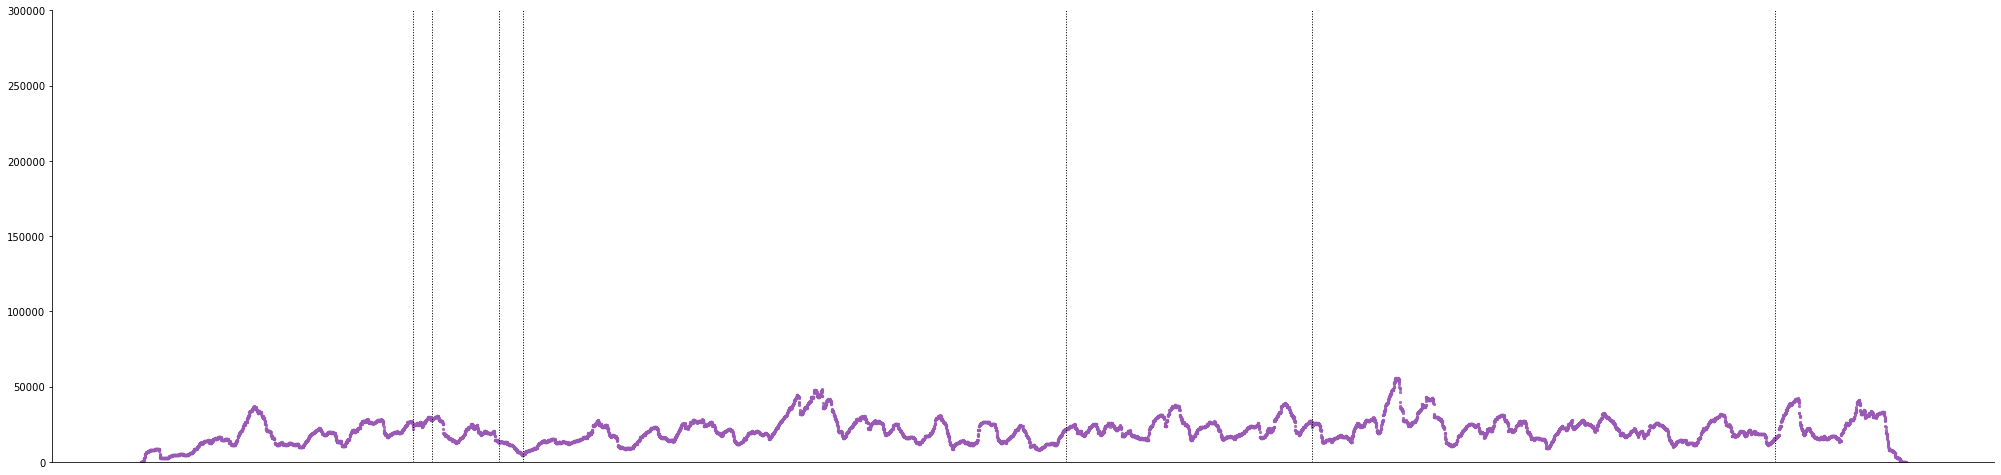

In [25]:
sns.set_palette(colors_51)
plotCoverage(tables_51, table_names_51)

# Figure S5

### Computing standard deviation of base frequencies at a site in an experiment

In [26]:
# Functions to think in terms of standard deviation of the frequency per site
def compute_sds(tables):
    num_tables = len(tables)
    first = tables[0]
    last = tables[num_tables-1]
    major = ""
    minor = ""
    major_frequencies = array('d',[0.0]*num_tables)
    minor_frequencies = array('d',[0.0]*num_tables)
    sds = list()
    for i in first["Position"]:
        major = first["Major_variant"][i]
        #print(last['Major_variant_frequency_quality_corrected'][i])
        major_frequencies[0] = first['Major_variant_frequency_quality_corrected'][i]
        for table_id in range(1, num_tables):
            major_frequencies[table_id] = get_variant_frequency(major, tables[table_id], i)
        sd_value = statistics.pstdev(major_frequencies)
        sds.append(sd_value)
    return sds

def get_varying_variants_sd(tables, sd_threshold):
    num_tables = len(tables)
    first = tables[0]
    last = tables[num_tables-1]
    major = ""
    minor = ""
    major_frequencies = array('d',[0.0]*num_tables)
    minor_frequencies = array('d',[0.0]*num_tables)
    varyingVariants = dict()
    for i in first["Position"]:
        major = first["Major_variant"][i]
        #print(last['Major_variant_frequency_quality_corrected'][i])
        major_frequencies[0] = first['Major_variant_frequency_quality_corrected'][i]
        for table_id in range(1, num_tables):
            major_frequencies[table_id] = get_variant_frequency(major, tables[table_id], i)
        sd_value = statistics.pstdev(major_frequencies)
        if sd_value > sd_threshold:
            varyingVariants[i] = sd_value
    print("There are "+str(len(varyingVariants))+" positions whose major variant varies a lot in frequency.")
    print("Those are:")
    print(varyingVariants.keys())
    return varyingVariants


### Defining a threshold of variation

In [27]:
# Compute all standard deviations for all sites for all experiments
sds_A = compute_sds(tables_A)
sds_D = compute_sds(tables_D)
sds_E = compute_sds(tables_E)

        

/home/boussau/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
/home/boussau/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


In [28]:
sds = list()
sds = sds + sds_A + sds_D + sds_E 
print(len(sds))

32421


Text(0, 0.5, 'Density')

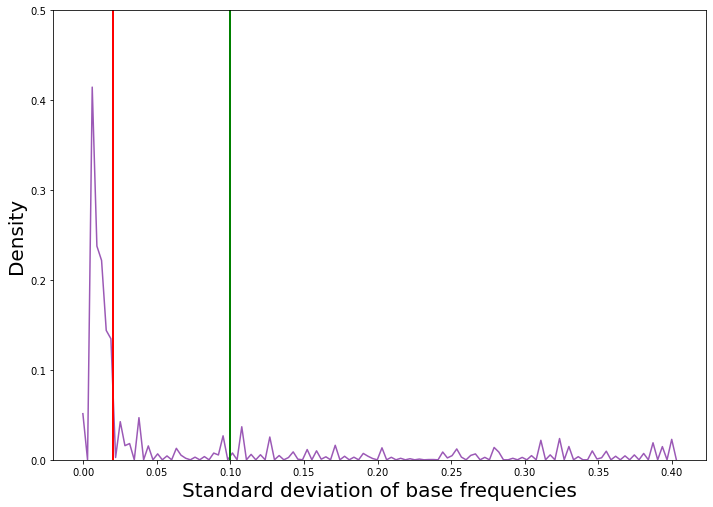

In [29]:
a4_dims = (11.7, 8.27)


fig, ax = plt.subplots(figsize=a4_dims)

ax2 = sns.kdeplot(sds)
ax2.set_ylim(0, 0.5)
sds_threshold = 0.02
plt.plot([sds_threshold, sds_threshold], [0, 0.5], linewidth=2, color="red")
plt.plot([0.1, 0.1], [0, 0.5], linewidth=2, color="green")
ax.set_xlabel('Standard deviation of base frequencies', fontsize=20)
ax.set_ylabel('Density',fontsize=20)
#b.set_xlabel("X Label",fontsize=30)
#b.set_ylabel("Y Label",fontsize=20)
#b.tick_params(labelsize=5)


In [30]:
num =0
for i in sds:
    if (i>sds_threshold):
        num = num +1
print("There are "+str(num) + " pairs position*experiments that have a standard deviation larger than the threshold "+str(sds_threshold))

There are 46 pairs position*experiments that have a standard deviation larger than the threshold 0.02


### Retrieving the highly variable variants: 0.02 threshold

In [43]:
varying_A = get_varying_variants_sd(tables_A, sds_threshold)
varying_D = get_varying_variants_sd(tables_D, sds_threshold)
varying_E = get_varying_variants_sd(tables_E, sds_threshold)


/home/boussau/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
/home/boussau/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


There are 15 positions whose major variant varies a lot in frequency.
Those are:
dict_keys([276, 316, 1419, 1670, 1785, 2340, 2593, 4691, 5662, 5935, 6044, 7172, 8449, 9165, 10006])
There are 17 positions whose major variant varies a lot in frequency.
Those are:
dict_keys([533, 926, 1785, 1916, 2069, 2177, 2185, 2193, 2340, 2935, 5662, 6558, 7172, 8466, 8710, 9703, 10006])
There are 14 positions whose major variant varies a lot in frequency.
Those are:
dict_keys([207, 346, 533, 768, 1785, 2193, 2340, 2359, 3566, 4297, 5479, 5662, 7172, 10006])


In [44]:
all_varying = [varying_A,varying_D,varying_E]
def build_table_for_plotting_varying_pos (all_varying):
    all_keys = list()
    for di in all_varying:
        all_keys = all_keys + list(di.keys())
    return(Counter(all_keys))
counts = build_table_for_plotting_varying_pos(all_varying)
print (counts)

Counter({1785: 3, 2340: 3, 5662: 3, 7172: 3, 10006: 3, 533: 2, 2193: 2, 276: 1, 316: 1, 1419: 1, 1670: 1, 2593: 1, 4691: 1, 5935: 1, 6044: 1, 8449: 1, 9165: 1, 926: 1, 1916: 1, 2069: 1, 2177: 1, 2185: 1, 2935: 1, 6558: 1, 8466: 1, 8710: 1, 9703: 1, 207: 1, 346: 1, 768: 1, 2359: 1, 3566: 1, 4297: 1, 5479: 1})


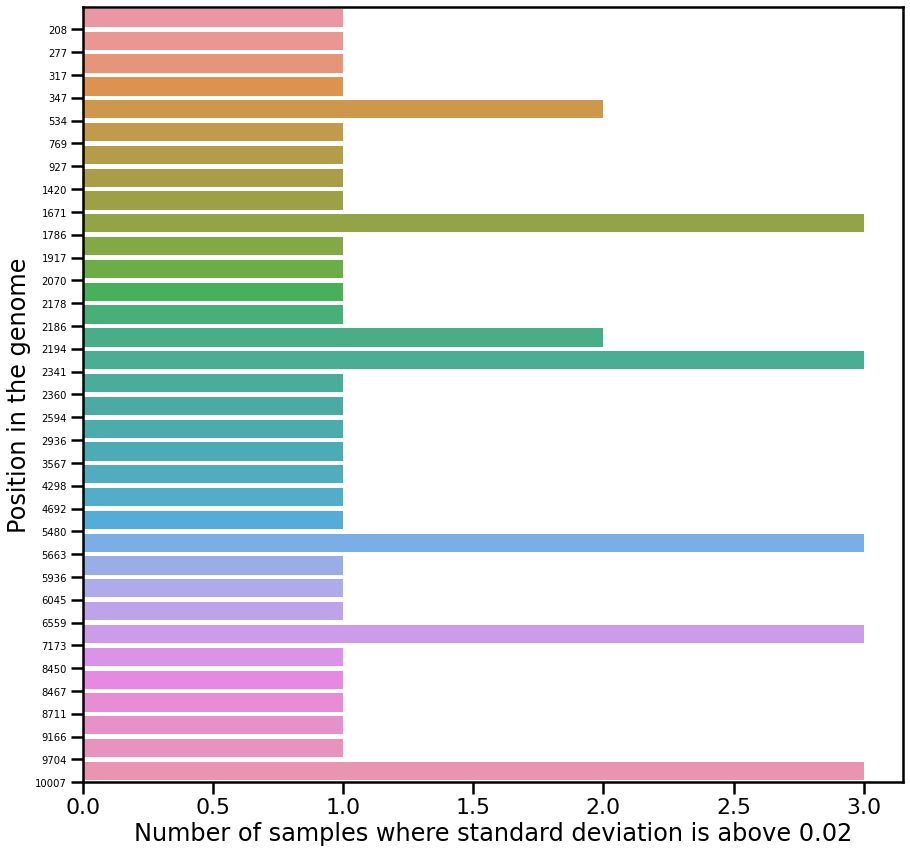

In [52]:

counts_sorted = sorted(counts.items())

labels, values = zip(*counts_sorted)

labels = list(labels)
# Renumbering to start at 1 and not 0, for the plot
for i in range(len(labels)):
    labels[i] = labels[i]+1

indexes = np.arange(len(labels))
width = 1


sns.set_palette("hls")
sns.set_context("poster")

a4_dims = (14.7, 14.27)

to_plot = pd.DataFrame ({'Position':indexes, 'standard_deviation':values}) 

fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(y="Position", x="standard_deviation", data=to_plot, orient="h")
ax.set(xlabel='Number of samples where standard deviation is above ' + str(sds_threshold), ylabel='Position in the genome')
plt.yticks(indexes + width * 0.5, labels, size=10)
plt.show()

Positions 1785, 2340, 5662, 7172 and 10006 vary a lot in all 3 experiments.

### Retrieving the highly variable variants: 0.1 threshold

/home/boussau/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
/home/boussau/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


There are 9 positions whose major variant varies a lot in frequency.
Those are:
dict_keys([276, 316, 1670, 1785, 2340, 5935, 7172, 8449, 9165])
There are 6 positions whose major variant varies a lot in frequency.
Those are:
dict_keys([1785, 1916, 2069, 2193, 2340, 7172])
There are 11 positions whose major variant varies a lot in frequency.
Those are:
dict_keys([346, 533, 1785, 2193, 2340, 2359, 3566, 4297, 5662, 7172, 10006])
Counter({1785: 3, 2340: 3, 7172: 3, 2193: 2, 276: 1, 316: 1, 1670: 1, 5935: 1, 8449: 1, 9165: 1, 1916: 1, 2069: 1, 346: 1, 533: 1, 2359: 1, 3566: 1, 4297: 1, 5662: 1, 10006: 1})


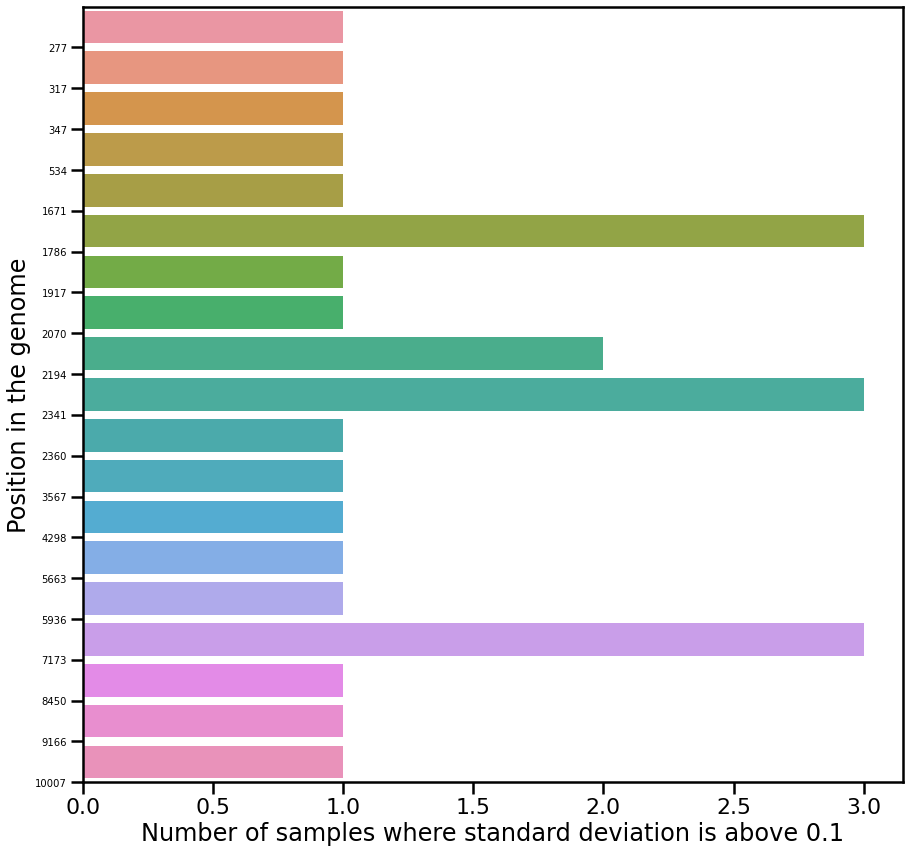

In [53]:
varying_A = get_varying_variants_sd(tables_A, 0.1)
varying_D = get_varying_variants_sd(tables_D, 0.1)
varying_E = get_varying_variants_sd(tables_E, 0.1)

all_varying = [varying_A,varying_D,varying_E]

counts = build_table_for_plotting_varying_pos(all_varying)
print (counts)

counts_sorted = sorted(counts.items())

labels, values = zip(*counts_sorted)


labels = list(labels)
# Renumbering to start at 1 and not 0, for the plot
for i in range(len(labels)):
    labels[i] = labels[i]+1


indexes = np.arange(len(labels))
width = 1


sns.set_palette("hls")
sns.set_context("poster")

a4_dims = (14.7, 14.27)

to_plot = pd.DataFrame ({'Position':indexes+1, 'standard_deviation':values}) 

fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(y="Position", x="standard_deviation", data=to_plot, orient="h")
ax.set(xlabel='Number of samples where standard deviation is above ' + str(0.1), ylabel='Position in the genome')
plt.yticks(indexes + width * 0.5, labels, size=10)
plt.show()

# Figure 5

In [40]:
def plotSecondVariant(tables, names):
    variable = 'Second_variant_frequency_quality_corrected'
    sample = list()
    posList = list()
    variableList = list()
    for i in range(len(names)):
        sample = sample + len(tables[i][variable]) * [names[i]]
        posList.append(tables[i]['Position'])
        variableList.append(tables[i][variable])
    positions = pd.concat(posList)
    variableValues = pd.concat(variableList)
    overlay_table_concat = pd.DataFrame ({'Position':positions, variable:variableValues, 'sample':sample})
    sns.lmplot( x="Position", y=variable, data=overlay_table_concat, fit_reg=False, hue='sample', legend=False, size=7, aspect=2)
#    plt.legend(loc='lower right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plot_positions()
    axes = plt.gca()
    axes.set_ylim([0,1.0])
    # Now a plot without text
    g=sns.lmplot( x="Position", y=variable, data=overlay_table_concat, fit_reg=False, hue='sample', legend=False, size=7, aspect=2)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plot_positions()
    g.set_ylabels("") 
    g.set_xlabels("") 
    g.set(xticks=[],yticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    axes = plt.gca()
    axes.set_ylim([0,1.0])
    # Now a plot without text and flat
    g=sns.lmplot( x="Position", y=variable, data=overlay_table_concat, fit_reg=False, hue='sample', legend=False, size=7, aspect=4)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plot_positions()
    g.set_ylabels("") 
    g.set_xlabels("") 
    g.set(xticks=[],yticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    axes = plt.gca()
    axes.set_ylim([0,1.0])
    

    #plot_genes()

## D_A

/home/boussau/anaconda3/lib/python3.7/site-packages/seaborn/regression.py:573: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


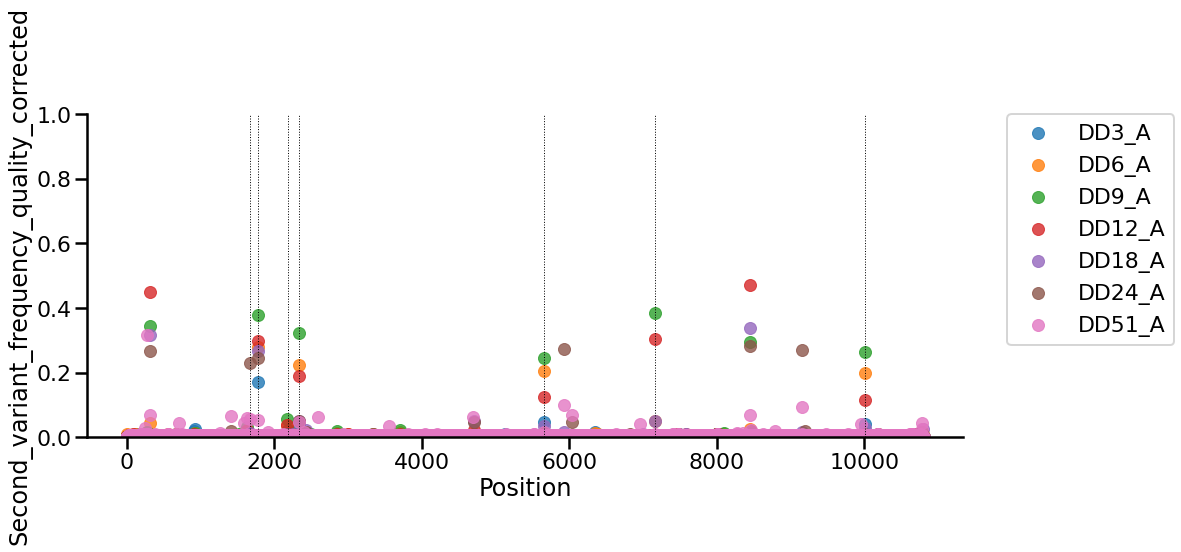

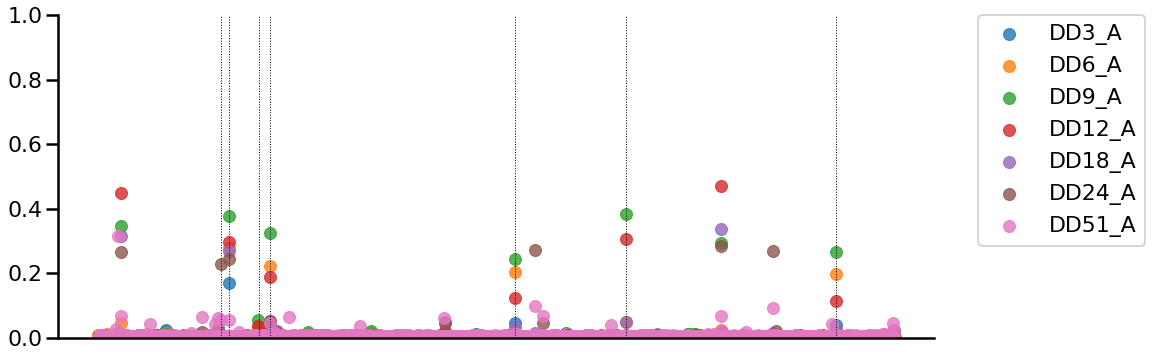

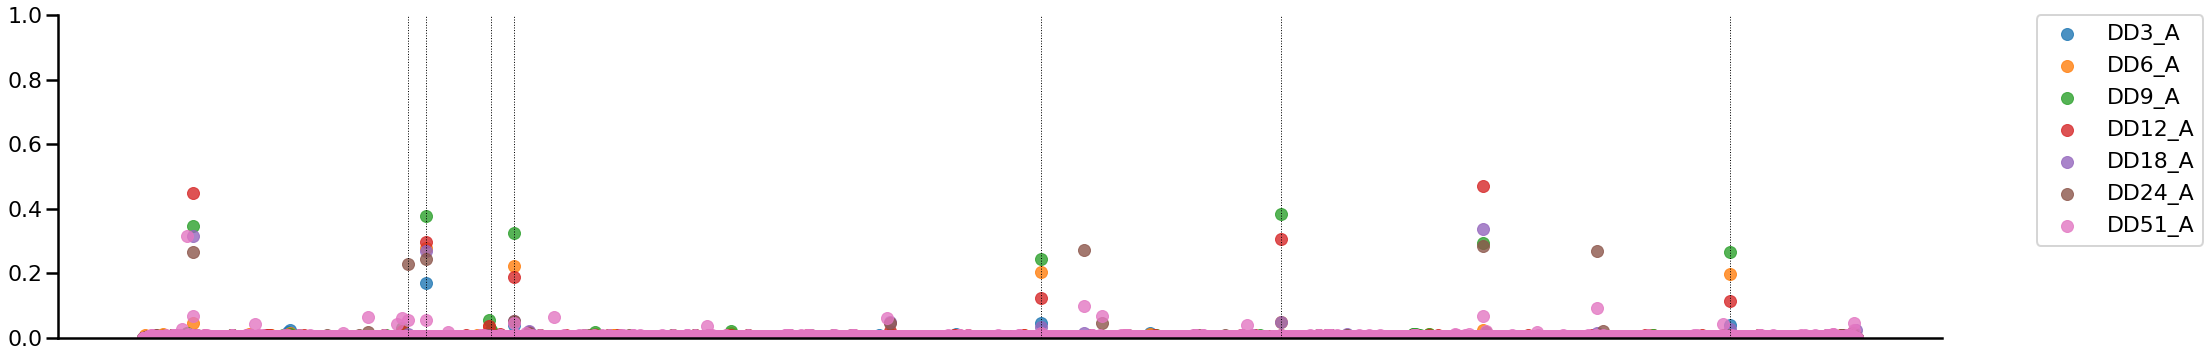

In [41]:
sns.set_palette(colors_A)
plotSecondVariant(tables_A, names_A)

## D_D

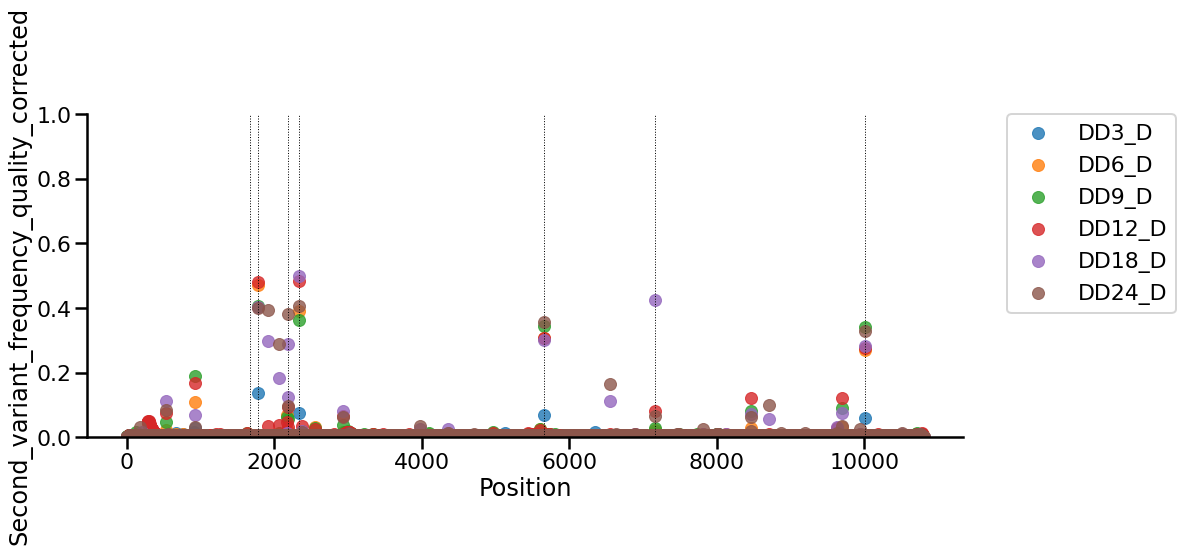

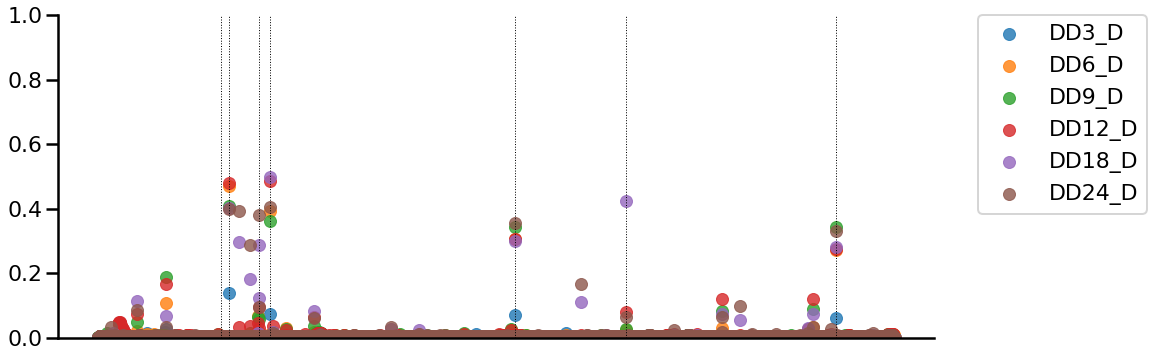

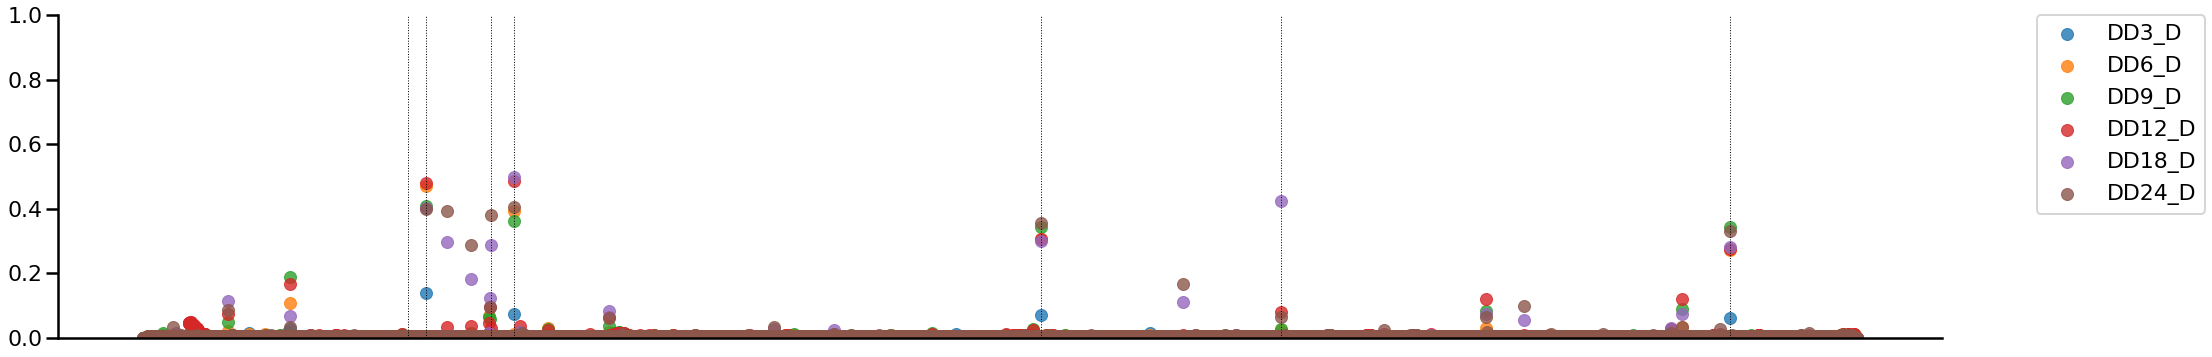

In [42]:
sns.set_palette(colors_D)
plotSecondVariant(tables_D, names_D)

## D_E

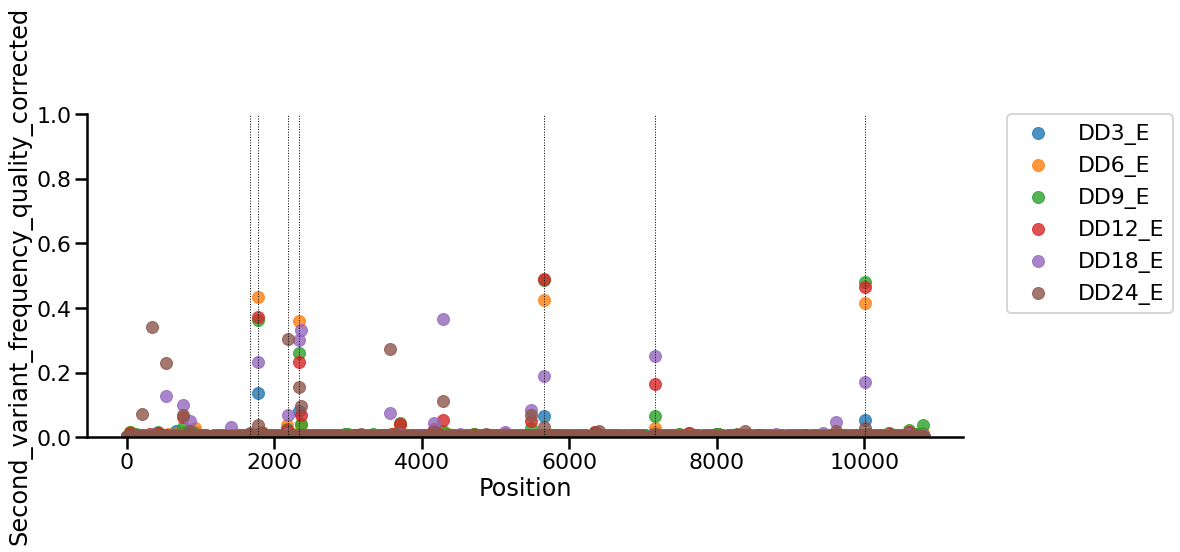

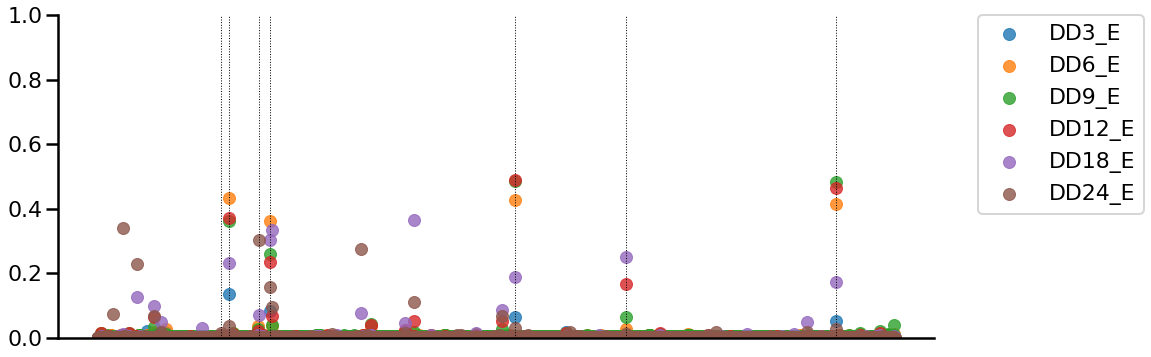

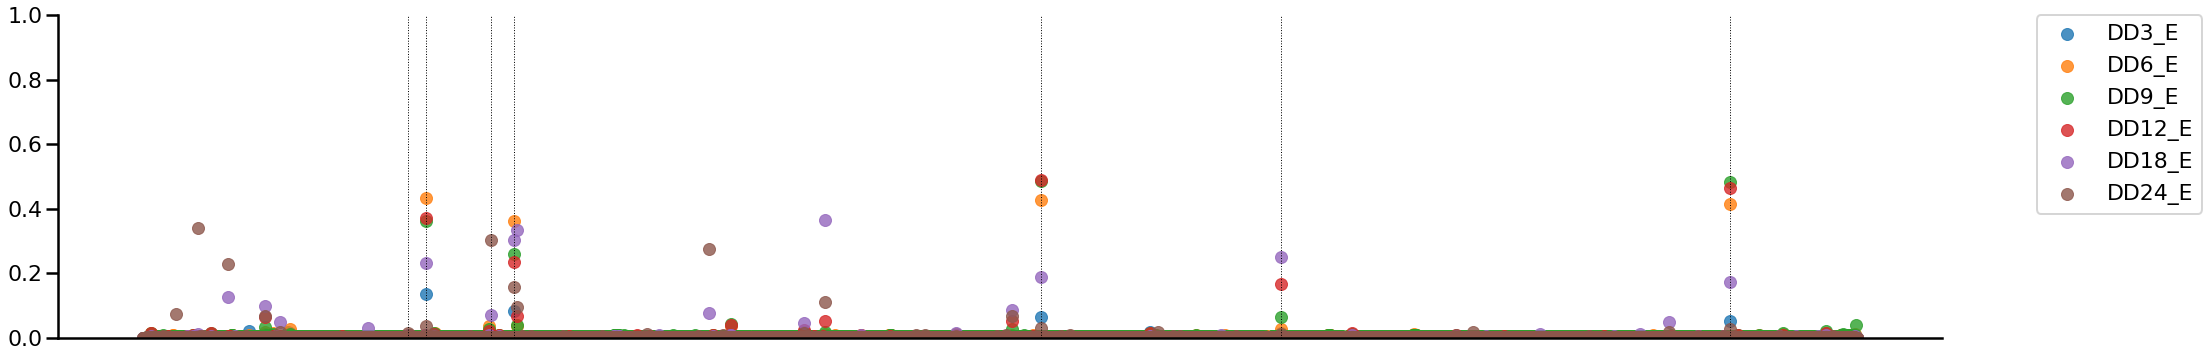

In [43]:
sns.set_palette(colors_E)
plotSecondVariant(tables_E, names_E)

# Average coverage per experiment

In [39]:
for i in range(len(all_tables)):
    avg = np.mean(all_tables[i]['Coverage'])
    print("Experiment "+ all_table_names[i] + " : " + str(avg))

Experiment DD3_A : 41702.322291107615
Experiment DD6_A : 95883.99555843436
Experiment DD9_A : 60795.55315998889
Experiment DD12_A : 22502.163690200796
Experiment DD18_A : 78241.87073193301
Experiment DD24_A : 37155.38012399371
Experiment DD51_A : 20677.340797631165
Experiment DD3_D : 70622.87970759693
Experiment DD6_D : 93014.95789765893
Experiment DD9_D : 74732.96900157306
Experiment DD12_D : 43679.84907930045
Experiment DD18_D : 86837.95262329972
Experiment DD24_D : 34472.01841399093
Experiment DD3_E : 31564.343666142315
Experiment DD6_E : 113196.35884149163
Experiment DD9_E : 81294.18256685481
Experiment DD12_E : 90902.8430646803
Experiment DD18_E : 70638.73193300639
Experiment DD24_E : 114136.33274729342


# Minimum coverage per position

In [40]:
print (len(all_tables[i]['Coverage']))
minCovPerPosition = [1000000000]*len(all_tables[i]['Coverage'])
for i in range(len(all_tables)):
    for site in range(len(all_tables[i]['Coverage'])):
        if (minCovPerPosition[site]> all_tables[i]['Coverage'][site]):
             minCovPerPosition[site] = all_tables[i]['Coverage'][site]

10807


In [42]:
nbInfOneThousand = 0
for i in range (len(minCovPerPosition)) : 
    if minCovPerPosition[i]  < 1000:
        nbInfOneThousand += 1
print(nbInfOneThousand)

55


# Analysis of the peak in second variant frequencies in N terminal in DD_A

In [45]:
def listAllSecondVariantsAboveThreshold(tables, names, threshold):
    variable = 'Second_variant_frequency_quality_corrected'
    sample = list()
    posList = list()
    variableList = list()
    for i in range(len(names)):
        sample = sample + len(tables[i][variable]) * [names[i]]
        posList.append(tables[i]['Position'])
        variableList.append(tables[i][variable])
        for j in range (len(tables[i][variable])):
            if (tables[i][variable][j] > threshold):
                print("Sample " + names[i] + " ; position " + str(j) + "; Second_variant_frequency_quality_corrected : " + str(tables[i][variable][j]))
   
    

In [46]:
listAllSecondVariantsAboveThreshold(tables_A, names_A, 0.2)

Sample DD6_A ; position 1785; Second_variant_frequency_quality_corrected : 0.279615
Sample DD6_A ; position 2340; Second_variant_frequency_quality_corrected : 0.224029
Sample DD6_A ; position 5662; Second_variant_frequency_quality_corrected : 0.204701
Sample DD9_A ; position 316; Second_variant_frequency_quality_corrected : 0.344913
Sample DD9_A ; position 1785; Second_variant_frequency_quality_corrected : 0.3769
Sample DD9_A ; position 2340; Second_variant_frequency_quality_corrected : 0.323548
Sample DD9_A ; position 5662; Second_variant_frequency_quality_corrected : 0.245315
Sample DD9_A ; position 7172; Second_variant_frequency_quality_corrected : 0.38415
Sample DD9_A ; position 8449; Second_variant_frequency_quality_corrected : 0.293926
Sample DD9_A ; position 10006; Second_variant_frequency_quality_corrected : 0.265002
Sample DD12_A ; position 316; Second_variant_frequency_quality_corrected : 0.448906
Sample DD12_A ; position 1785; Second_variant_frequency_quality_corrected : 0.2

# New analysis: plotting the standard deviations of varying positions across experiments
We plot the standard deviations for all positions that have passed the standard deviation threshold in at least one experiment. The value for the threshold is displayed with a horizontal dotted line.

(0.0, 0.5)

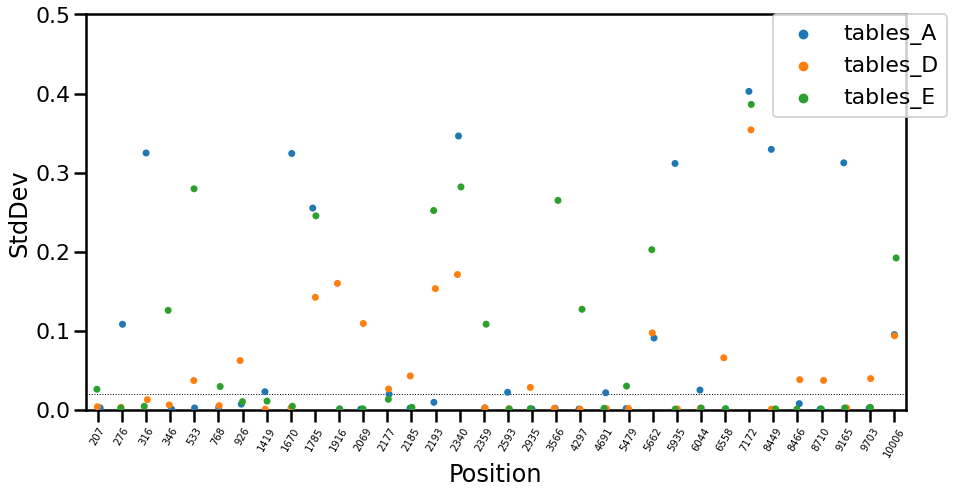

In [47]:
# list of all highly varying variants in at least one experiment: all_varying

def get_all_varying_pos (all_varying):
    all_keys = list()
    for di in all_varying:
        all_keys = all_keys + list(di.keys())
    temp = list(dict.fromkeys(all_keys))
    temp.sort()
    return( temp )

all_varying_keys = get_all_varying_pos(all_varying)

def get_sd_for_select_variants(variants, tables):
    sd_values = list()
    num_tables = len(tables)
    first = tables[0]
    last = tables[num_tables-1]
    major = ""
    minor = ""
    major_frequencies = array('d',[0.0]*num_tables)
    minor_frequencies = array('d',[0.0]*num_tables)
    varyingVariants = dict()
    for i in variants:
        major = first["Major_variant"][i]
        major_frequencies[0] = first['Major_variant_frequency_quality_corrected'][i]
        for table_id in range(1, num_tables):
            major_frequencies[table_id] = get_variant_frequency(major, tables[table_id], i)
        sd_value = statistics.pstdev(major_frequencies)
        sd_values.append(sd_value)
    return sd_values

sample = list()
variableList = list()
pos = list()
for i in range(len(all_experiments)):
    sample = sample + len(all_varying_keys) * [all_experiment_names[i]]
    variableList = variableList + get_sd_for_select_variants(all_varying_keys, all_experiments[i])
    pos = pos + all_varying_keys
positions = pos
variableValues = variableList
overlay_table_concat = pd.DataFrame ({'Position':positions, 'StdDev':variableValues, 'sample':sample})

a4_dims = (14.7, 7.27)
fig, ax = plt.subplots(figsize=a4_dims)

g = sns.stripplot( x="Position", y='StdDev', data=overlay_table_concat, hue='sample', size=7)
# Horizontal line for the threshold sds_threshold
plt.axhline(y=sds_threshold, linewidth=1, linestyle=':', color="black")
#g.set_xlabels(positions, rotation=30) 
#g.set(xticks=[],yticks=[0,50000,100000,150000, 200000, 250000, 300000])
g.set_xticklabels(positions, rotation=60, fontdict={'fontsize':10})
plt.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)
axes = plt.gca()
axes.set_ylim([0,0.5])



### Same plot, without the legend

(0.0, 0.5)

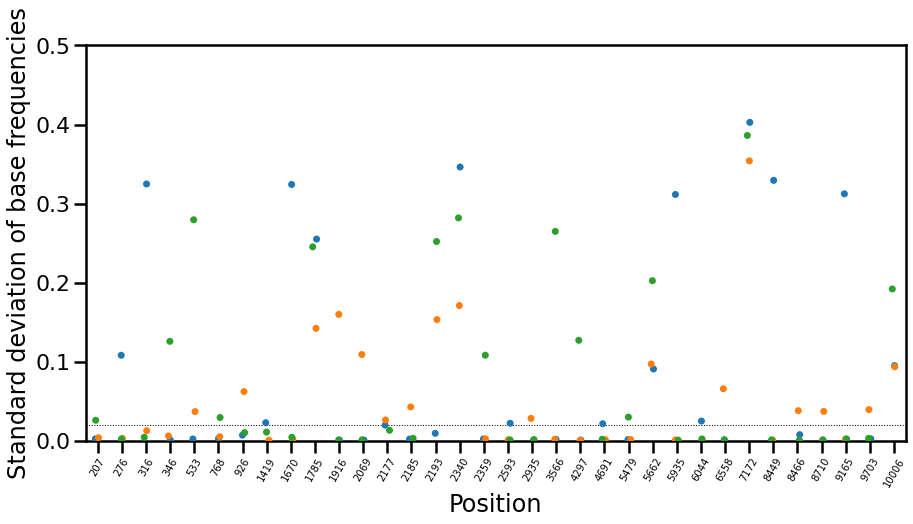

In [48]:

a4_dims = (14.7, 7.27)
fig, ax = plt.subplots(figsize=a4_dims)

g = sns.stripplot( x="Position", y='StdDev', data=overlay_table_concat, hue='sample', size=7)
g.legend_.remove()
g.set(ylabel='Standard deviation of base frequencies')
# Horizontal line for the threshold sds_threshold
plt.axhline(y=sds_threshold, linewidth=1, linestyle=':', color="black")
#g.set_xlabels(positions, rotation=30) 
#g.set(xticks=[],yticks=[0,50000,100000,150000, 200000, 250000, 300000])
g.set_xticklabels(positions, rotation=60, fontdict={'fontsize':10})
axes = plt.gca()
axes.set_ylim([0,0.5])

### Same plot, without the legend and without the axis label

(0.0, 0.5)

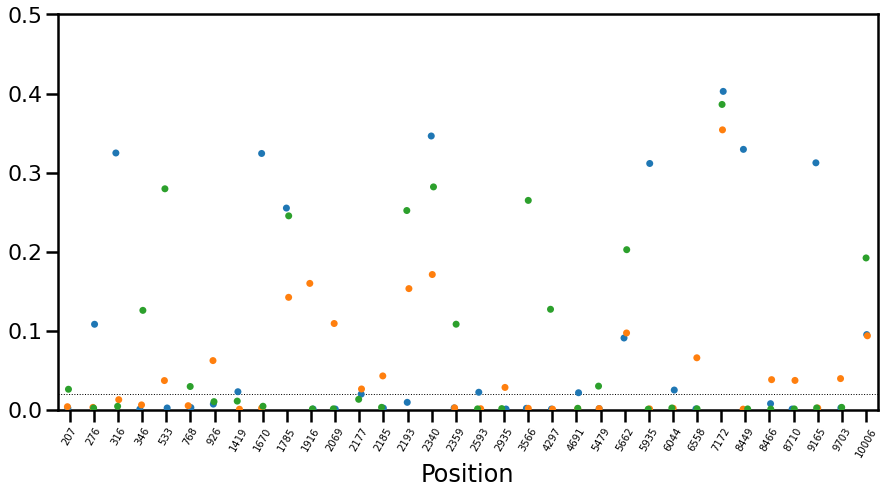

In [49]:

a4_dims = (14.7, 7.27)
fig, ax = plt.subplots(figsize=a4_dims)

g = sns.stripplot( x="Position", y='StdDev', data=overlay_table_concat, hue='sample', size=7)
g.legend_.remove()
g.set(ylabel='')
# Horizontal line for the threshold sds_threshold
plt.axhline(y=sds_threshold, linewidth=1, linestyle=':', color="black")
#g.set_xlabels(positions, rotation=30) 
#g.set(xticks=[],yticks=[0,50000,100000,150000, 200000, 250000, 300000])
g.set_xticklabels(positions, rotation=60, fontdict={'fontsize':10})
axes = plt.gca()
axes.set_ylim([0,0.5])

## Plotting variant frequencies for specific time points

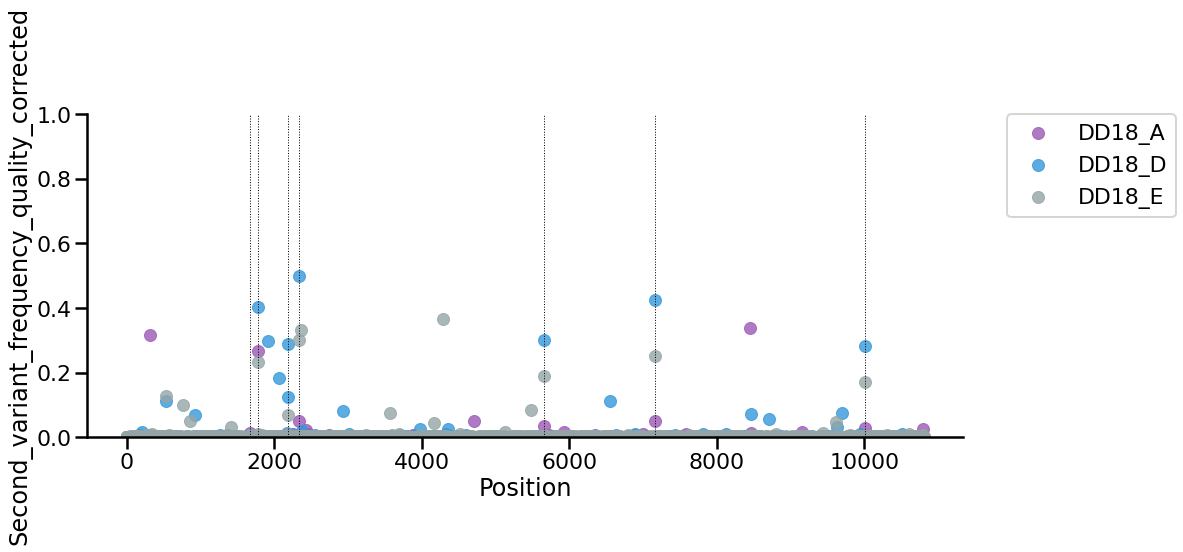

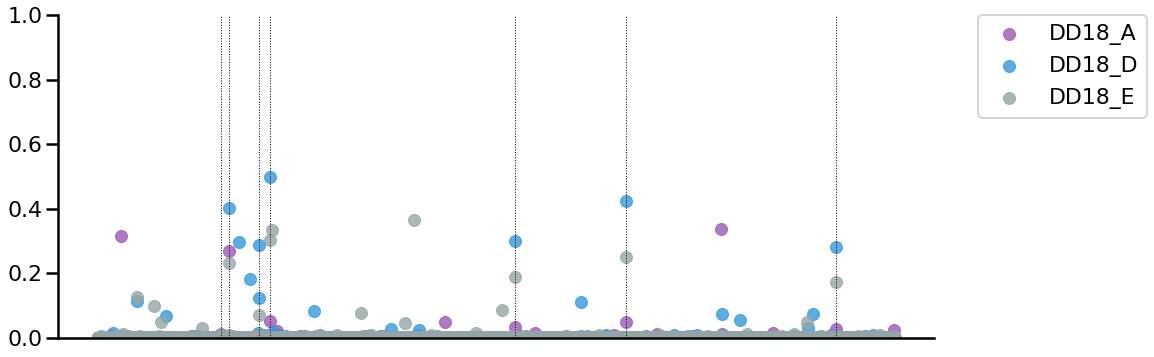

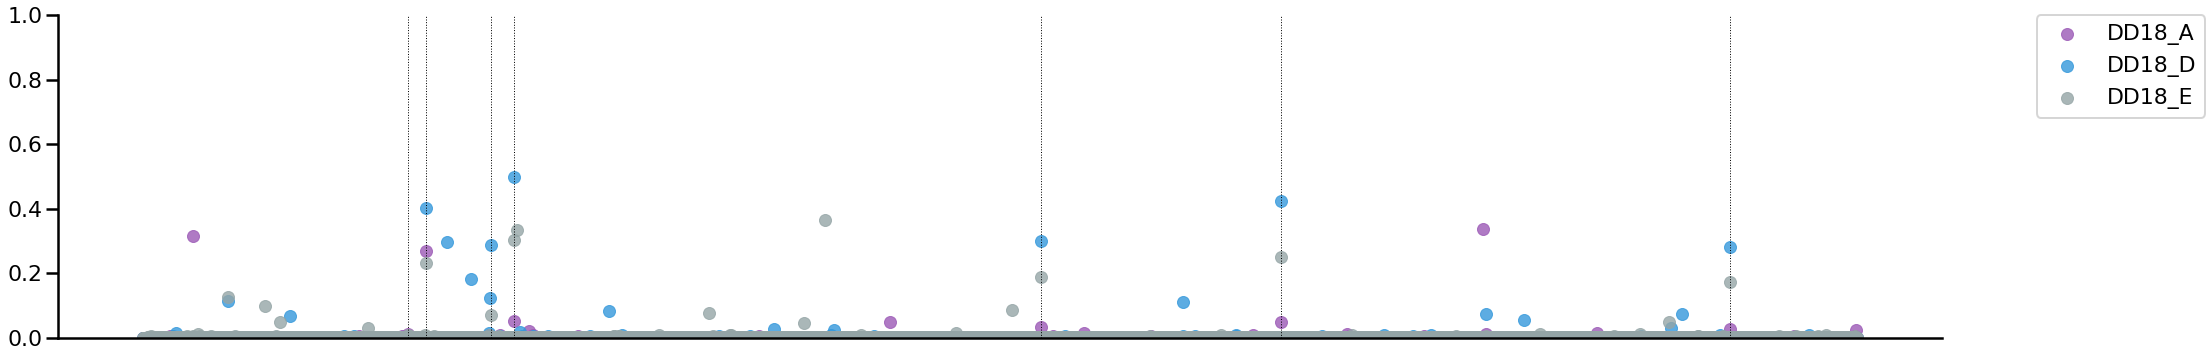

In [50]:
sns.set_palette(colors_18)
positions = [1670, 2340, 5662, 7172, 10006, 2193, 1785]
plotSecondVariant(tables_18, table_names_18)
#plotCoverage(tables_18, table_names_18)